# PHÂN TÍCH CÁC YẾU TỐ ẢNH HƯỞNG ĐẾN ĐIỂM THI

## Mục tiêu:
- Khám phá và phân tích dữ liệu các yếu tố ảnh hưởng đến điểm thi
- Xây dựng mô hình dự đoán điểm thi dựa trên các yếu tố
- Đánh giá mức độ quan trọng của từng yếu tố

## Mục lục và hướng dẫn chạy

- 1. Import thư viện và load dữ liệu
- 2. Khám phá dữ liệu (EDA)
  - 2.1 Tổng quan dữ liệu
  - 2.2 Biến số (numeric)
  - 2.3 Scatter plots
  - 2.4 Biến phân loại (categorical)
  - 2.5 Biểu đồ phân phối categorical
- 3. Chuẩn bị dữ liệu cho mô hình
  - 3.1 Label Encoding
  - 3.2 Pipeline tiền xử lý
  - 3.3 Chia Train/Test
- 4. Xây dựng và đánh giá mô hình
  - 4.1 So sánh nhiều mô hình
  - 4.2 Tối ưu siêu tham số (Random Forest)
  - 4.3 Feature Importance
  - 4.4 Cross-validation
- 5. Kết luận

Gợi ý:
- Chạy lần lượt từ trên xuống dưới (Run All) để đảm bảo biến và pipeline được thiết lập đúng.
- Nếu bạn muốn thay đổi tham số mặc định (random seed, số folds…), sửa ở ô "Cấu hình hiển thị & tham số chung" phía dưới.

---
## 1. IMPORT THƯ VIỆN VÀ LOAD DỮ LIỆU

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Cấu hình hiển thị & tham số chung
from IPython.display import display, HTML
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

RANDOM_STATE = 42
N_FOLDS = 5

print("Cấu hình hiển thị và tham số chung đã sẵn sàng.")

Cấu hình hiển thị và tham số chung đã sẵn sàng.


In [3]:
# Load dữ liệu
df = pd.read_csv("data_warehouse/other_factors.csv")
print("Đã load dữ liệu thành công!")
print(f"Kích thước dữ liệu: {df.shape[0]} dòng, {df.shape[1]} cột\n")
display(df.head())

Đã load dữ liệu thành công!
Kích thước dữ liệu: 6607 dòng, 20 cột



,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


---
## 2. KHÁM PHÁ DỮ LIỆU (EDA)

### 2.1. Tổng quan về dữ liệu

In [4]:
# Thông tin cơ bản về dữ liệu
print("THÔNG TIN CƠ BẢN VỀ DỮ LIỆU")
print(f"\nKích thước: {df.shape}")
print(f"\nKiểu dữ liệu:\n")
print(df.dtypes)
print(f"\nThống kê mô tả:\n")
display(df.describe(include='all').T)

THÔNG TIN CƠ BẢN VỀ DỮ LIỆU

Kích thước: (6607, 20)

Kiểu dữ liệu:

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

Thống kê mô tả:



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours_Studied,"6,607.00",NaN,NaN,NaN,19.98,5.99,1.00,16.00,20.00,24.00,44.00
Attendance,"6,607.00",NaN,NaN,NaN,79.98,11.55,60.00,70.00,80.00,90.00,100.00
Parental_Involvement,6607,3,Medium,3362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Access_to_Resources,6607,3,Medium,3319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extracurricular_Activities,6607,2,Yes,3938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep_Hours,"6,607.00",NaN,NaN,NaN,7.03,1.47,4.00,6.00,7.00,8.00,10.00
Previous_Scores,"6,607.00",NaN,NaN,NaN,75.07,14.40,50.00,63.00,75.00,88.00,100.00
Motivation_Level,6607,3,Medium,3351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Internet_Access,6607,2,Yes,6108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tutoring_Sessions,"6,607.00",NaN,NaN,NaN,1.49,1.23,0.00,1.00,1.00,2.00,8.00


In [5]:
# Kiểm tra missing values
print("KIỂM TRA GIÁ TRỊ THIẾU (MISSING VALUES)\n")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Số lượng thiếu': missing_data,
    'Phần trăm (%)': missing_percent
}).sort_values('Số lượng thiếu', ascending=False)

# Chỉ hiển thị những cột có thiếu dữ liệu
missing_filtered = missing_df[missing_df['Số lượng thiếu'] > 0]
if not missing_filtered.empty:
    display(missing_filtered)
else:
    print("Không có giá trị thiếu.")

KIỂM TRA GIÁ TRỊ THIẾU (MISSING VALUES)



,Số lượng thiếu,Phần trăm (%)
Parental_Education_Level,90,1.36
Teacher_Quality,78,1.18
Distance_from_Home,67,1.01


### 2.2. Phân tích biến số (Numeric Features)

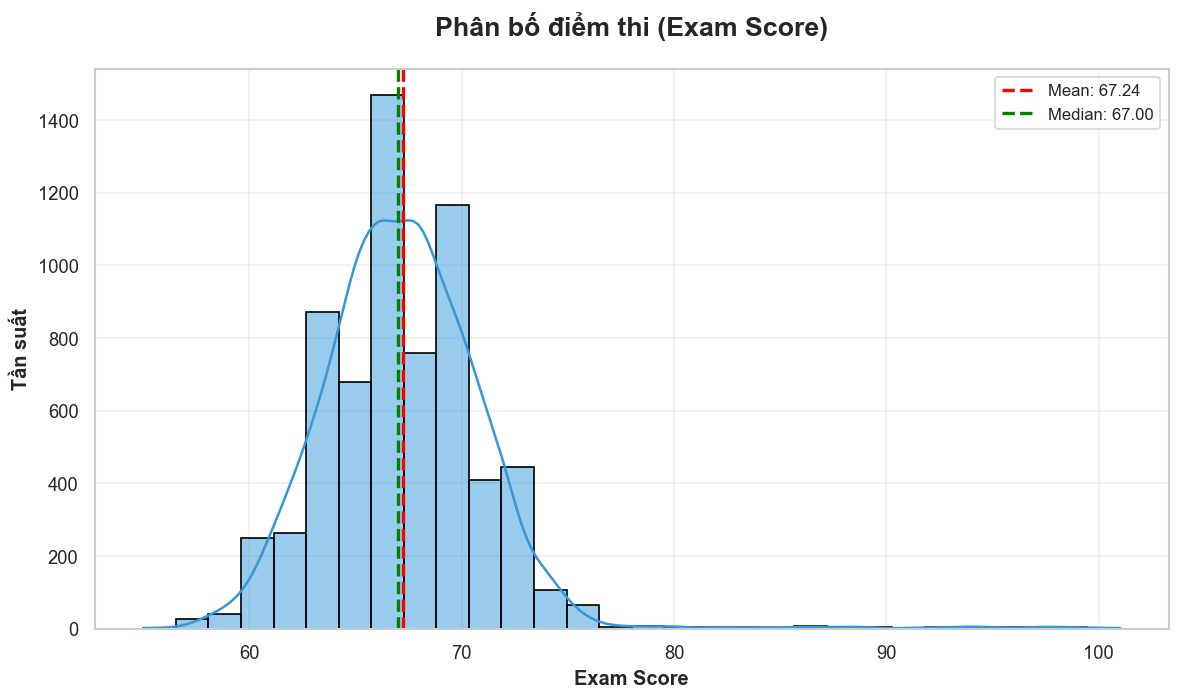

Thống kê Exam_Score:
   - Mean: 67.24
   - Median: 67.00
   - Std: 3.89
   - Min: 55.00
   - Max: 101.00


In [6]:
# Phân bố của Exam_Score (biến mục tiêu)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

if 'Exam_Score' in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Exam_Score'], kde=True, bins=30, color='#3498DB', edgecolor='black')
    plt.axvline(df['Exam_Score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Exam_Score"].mean():.2f}')
    plt.axvline(df['Exam_Score'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["Exam_Score"].median():.2f}')
    plt.title('Phân bố điểm thi (Exam Score)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Exam Score', fontsize=12, fontweight='bold')
    plt.ylabel('Tần suất', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Thống kê Exam_Score:")
    print(f"   - Mean: {df['Exam_Score'].mean():.2f}")
    print(f"   - Median: {df['Exam_Score'].median():.2f}")
    print(f"   - Std: {df['Exam_Score'].std():.2f}")
    print(f"   - Min: {df['Exam_Score'].min():.2f}")
    print(f"   - Max: {df['Exam_Score'].max():.2f}")

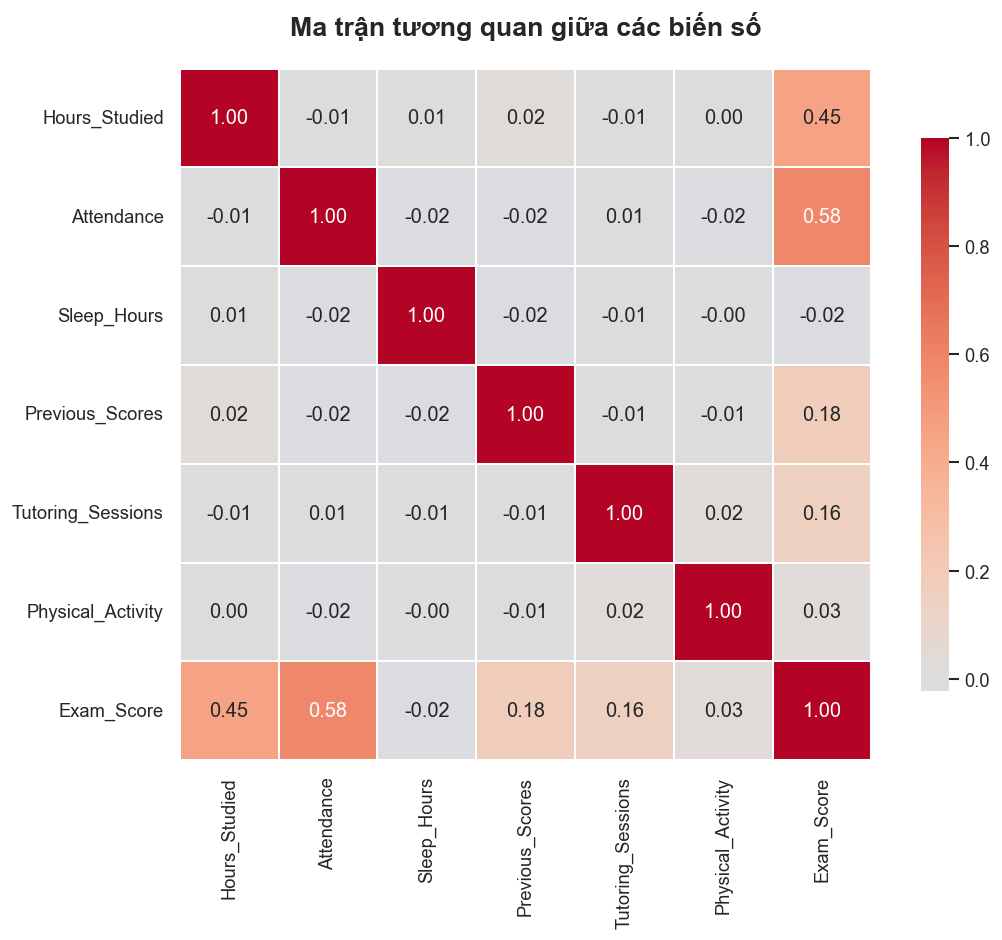


Tương quan với Exam_Score (sắp xếp theo độ mạnh):

   Attendance               :  0.581 (Dương - Mạnh)
   Hours_Studied            :  0.445 (Dương - Trung bình)
   Previous_Scores          :  0.175 (Dương - Yếu)
   Tutoring_Sessions        :  0.157 (Dương - Yếu)
   Physical_Activity        :  0.028 (Dương - Yếu)
   Sleep_Hours              : -0.017 (Âm - Yếu)


In [7]:
# Correlation heatmap cho các biến số
plt.figure(figsize=(10, 8))
correlation_matrix = df[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận tương quan giữa các biến số', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# In ra các tương quan mạnh với Exam_Score
if 'Exam_Score' in num_cols:
    print("\nTương quan với Exam_Score (sắp xếp theo độ mạnh):\n")
    exam_corr = correlation_matrix['Exam_Score'].sort_values(ascending=False)
    for feature, corr in exam_corr.items():
        if feature != 'Exam_Score':
            strength = "Rất mạnh" if abs(corr) > 0.7 else "Mạnh" if abs(corr) > 0.5 else "Trung bình" if abs(corr) > 0.3 else "Yếu"
            direction = "Dương" if corr > 0 else "Âm"
            print(f"   {feature:25s}: {corr:6.3f} ({direction} - {strength})")

### 2.3. Scatter plots - Biến số vs Exam Score

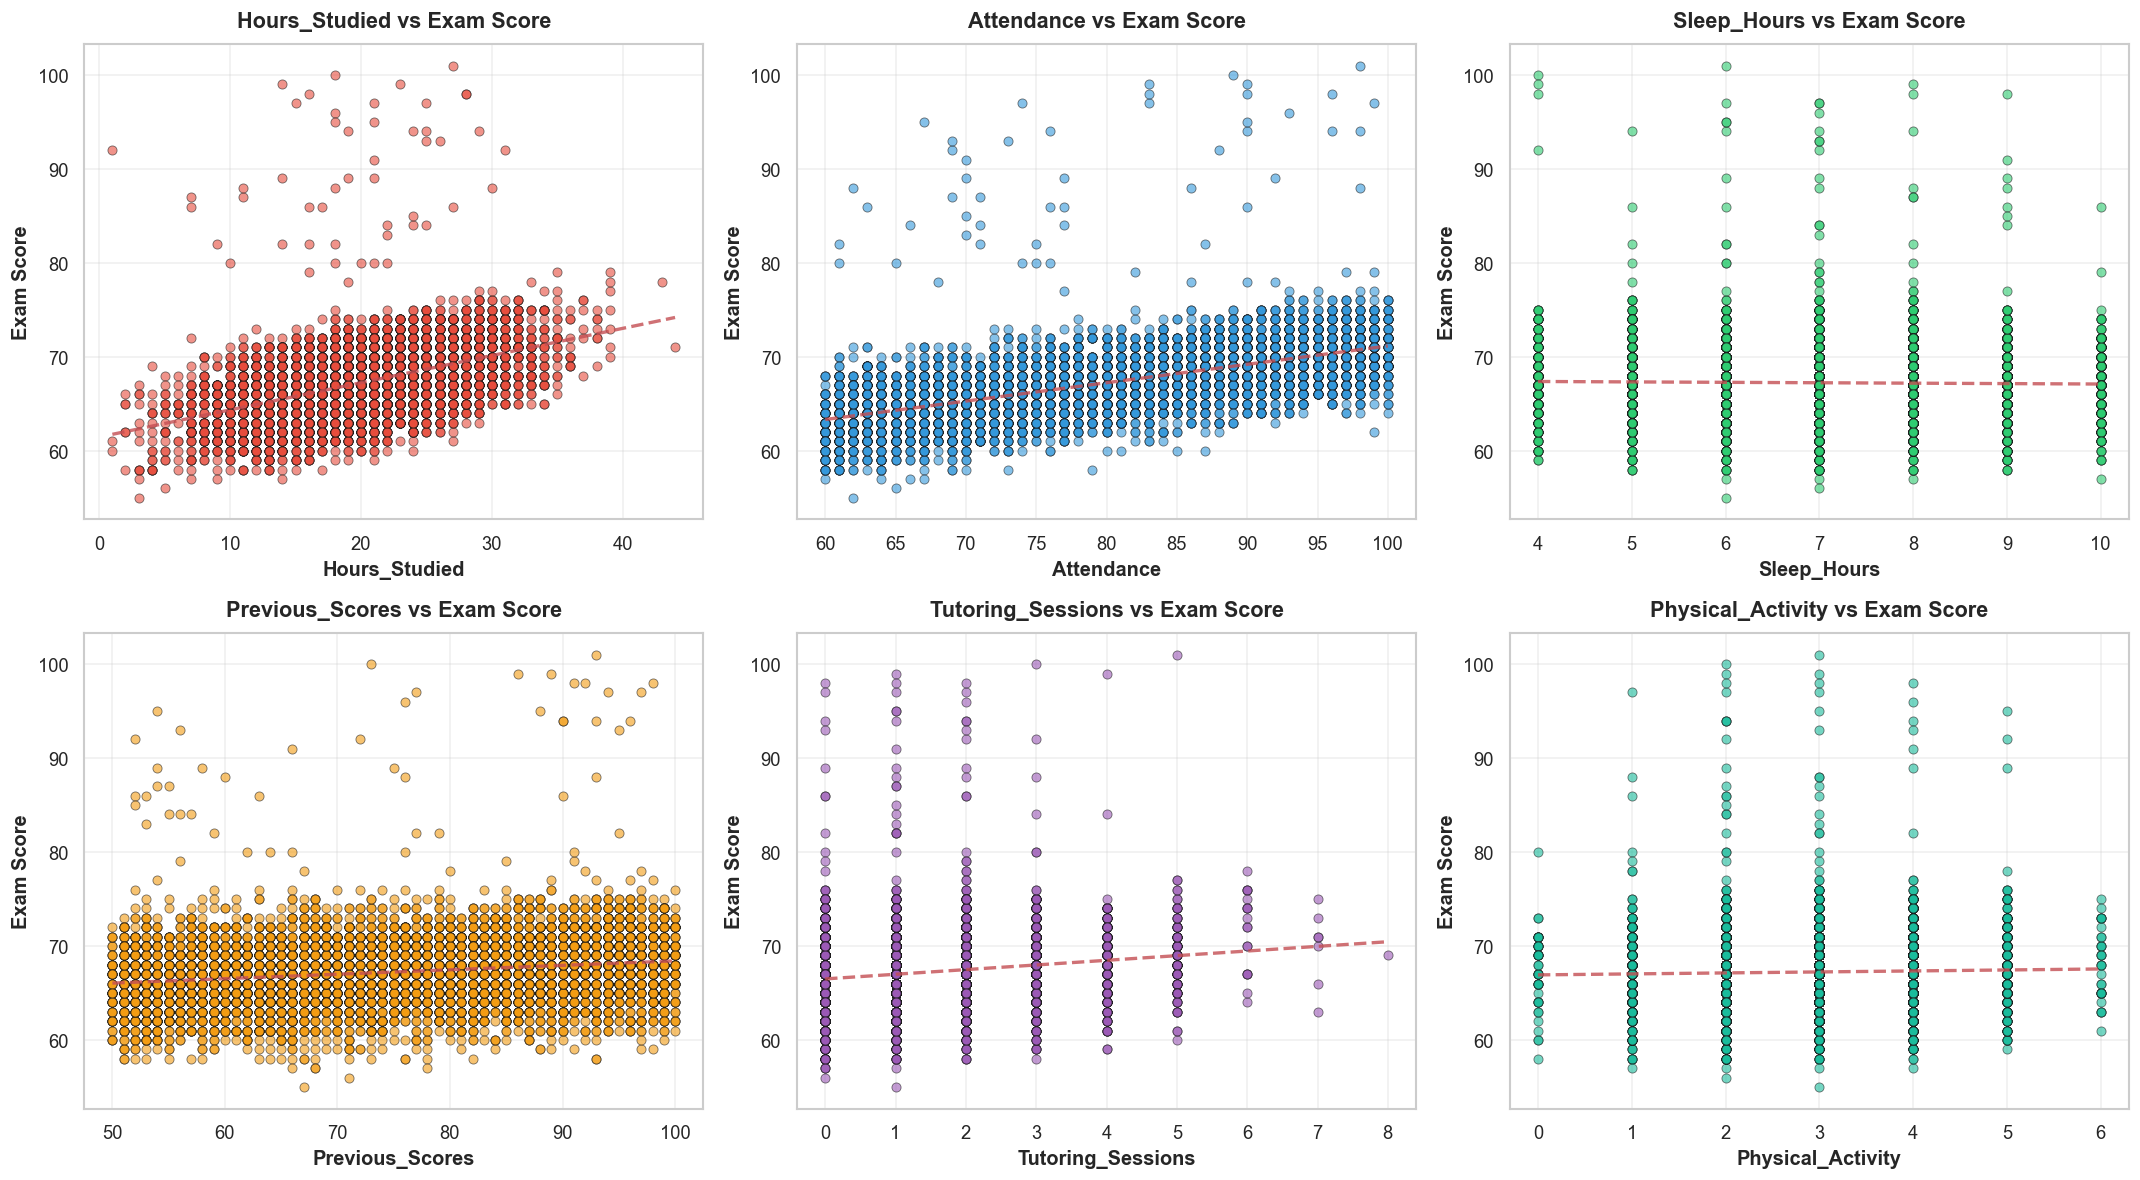

In [8]:
# Scatter plots cho các biến số vs Exam_Score
numeric_cols = [c for c in df.select_dtypes(include=['int64', 'float64']).columns 
                if c != 'Exam_Score']

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten() if len(numeric_cols) > 1 else [axes]
    
    scatter_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#E67E22', '#95A5A6']
    
    for idx, col in enumerate(numeric_cols):
        color = scatter_colors[idx % len(scatter_colors)]
        axes[idx].scatter(df[col], df['Exam_Score'], alpha=0.6, s=30, 
                         c=color, edgecolors='k', linewidth=0.5)
        
        # Thêm regression line
        z = np.polyfit(df[col].dropna(), df.loc[df[col].notna(), 'Exam_Score'], 1)
        p = np.poly1d(z)
        axes[idx].plot(df[col].sort_values(), p(df[col].sort_values()), 
                      "r--", alpha=0.8, linewidth=2)
        
        axes[idx].set_xlabel(col, fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Exam Score', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{col} vs Exam Score', fontsize=13, pad=10, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy biến số (ngoài Exam_Score)")

### **Nhận xét về Scatter Plots:**

**1. Hours_Studied vs Exam Score**
- **Tương quan dương khá mạnh (0.45)**
- Xu hướng rõ rệt: Học nhiều giờ → Điểm cao hơn
- Đây là một trong những yếu tố quan trọng nhất

**2. Attendance vs Exam Score**
- **Tương quan dương mạnh nhất (0.58)**
- Đi học đều đặn có ảnh hưởng lớn đến kết quả học tập
- Yếu tố QUAN TRỌNG NHẤT trong các biến số

**3. Sleep_Hours vs Exam Score**
- **Tương quan rất yếu (-0.02)**
- Không thấy mối quan hệ rõ ràng
- Giấc ngủ có thể không phải yếu tố quyết định

**4. Previous_Scores vs Exam Score**
- **Tương quan dương yếu (0.18)**
- Điểm cũ cao → Điểm hiện tại cao hơn một chút
- Học lực nền tảng có vai trò nhưng không quá lớn

**5. Tutoring_Sessions vs Exam Score**
- **Tương quan rất yếu (0.16)**
- Học thêm nhiều không đảm bảo điểm cao
- Có thể phụ thuộc vào chất lượng lớp học thêm

**6. Physical_Activity vs Exam Score**
- **Tương quan gần như không có (0.03)**
- Hoạt động thể chất không ảnh hưởng đáng kể đến điểm thi

### 2.4. Phân tích biến phân loại (Categorical Features)

In [9]:
# Xem các biến categorical
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("CÁC BIẾN PHÂN LOẠI (CATEGORICAL FEATURES)")
print(f"\nSố lượng: {len(categorical_cols)} biến")
print(f"\nDanh sách: {categorical_cols}")
print("\nGIÁ TRỊ ĐỘC NHẤT CỦA TỪNG BIẾN")

for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"\n{col}:")
    print(f"  - Số lượng giá trị: {len(unique_vals)}")
    print(f"  - Các giá trị: {unique_vals}")

CÁC BIẾN PHÂN LOẠI (CATEGORICAL FEATURES)

Số lượng: 13 biến

Danh sách: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']

GIÁ TRỊ ĐỘC NHẤT CỦA TỪNG BIẾN

Parental_Involvement:
  - Số lượng giá trị: 3
  - Các giá trị: ['Low' 'Medium' 'High']

Access_to_Resources:
  - Số lượng giá trị: 3
  - Các giá trị: ['High' 'Medium' 'Low']

Extracurricular_Activities:
  - Số lượng giá trị: 2
  - Các giá trị: ['No' 'Yes']

Motivation_Level:
  - Số lượng giá trị: 3
  - Các giá trị: ['Low' 'Medium' 'High']

Internet_Access:
  - Số lượng giá trị: 2
  - Các giá trị: ['Yes' 'No']

Family_Income:
  - Số lượng giá trị: 3
  - Các giá trị: ['Low' 'Medium' 'High']

Teacher_Quality:
  - Số lượng giá trị: 4
  - Các giá trị: ['Medium' 'High' 'Low' nan]

School_Type:
  - Số lượng giá trị: 2
  - 

In [10]:
# Thống kê Exam Score theo từng biến categorical
print("THỐNG KÊ EXAM SCORE THEO TỪNG BIẾN PHÂN LOẠI\n")

for col in categorical_cols:
    print(f"\n{col}")
    print(df.groupby(col)['Exam_Score'].describe().round(2))
    print(f"\nĐiểm trung bình theo {col} (sắp xếp giảm dần):")
    mean_scores = df.groupby(col)['Exam_Score'].mean().sort_values(ascending=False).round(2)
    for category, score in mean_scores.items():
        print(f"   {str(category):30s}: {score:.2f}")
    print("\n")

THỐNG KÊ EXAM SCORE THEO TỪNG BIẾN PHÂN LOẠI


Parental_Involvement
                        count  mean  std   min   25%   50%   75%    max
Parental_Involvement                                                   
High                 1,908.00 68.09 3.95 57.00 66.00 68.00 70.00 100.00
Low                  1,337.00 66.36 3.97 56.00 64.00 66.00 69.00 101.00
Medium               3,362.00 67.10 3.73 55.00 65.00 67.00 69.00  97.00

Điểm trung bình theo Parental_Involvement (sắp xếp giảm dần):
   High                          : 68.09
   Medium                        : 67.10
   Low                           : 66.36



Access_to_Resources
                       count  mean  std   min   25%   50%   75%    max
Access_to_Resources                                                   
High                1,975.00 68.09 3.95 56.00 66.00 68.00 70.00  99.00
Low                 1,313.00 66.20 3.56 55.00 64.00 66.00 68.00  98.00
Medium              3,319.00 67.13 3.87 58.00 65.00 67.00 69.00 101.00

Điểm tr

### 2.5. Biểu đồ phân phối các biến categorical

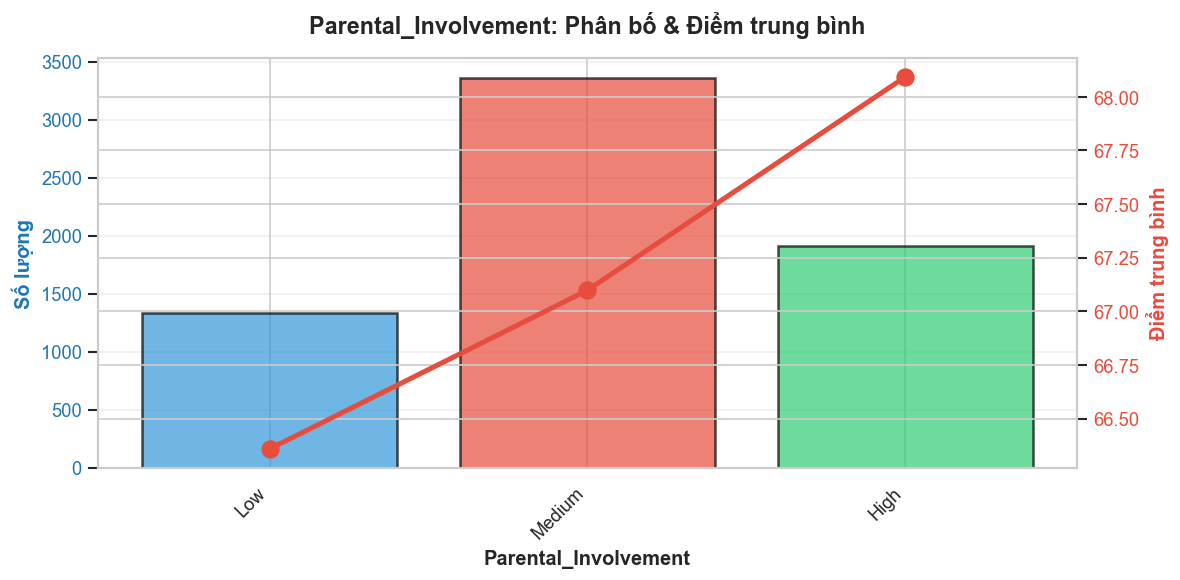

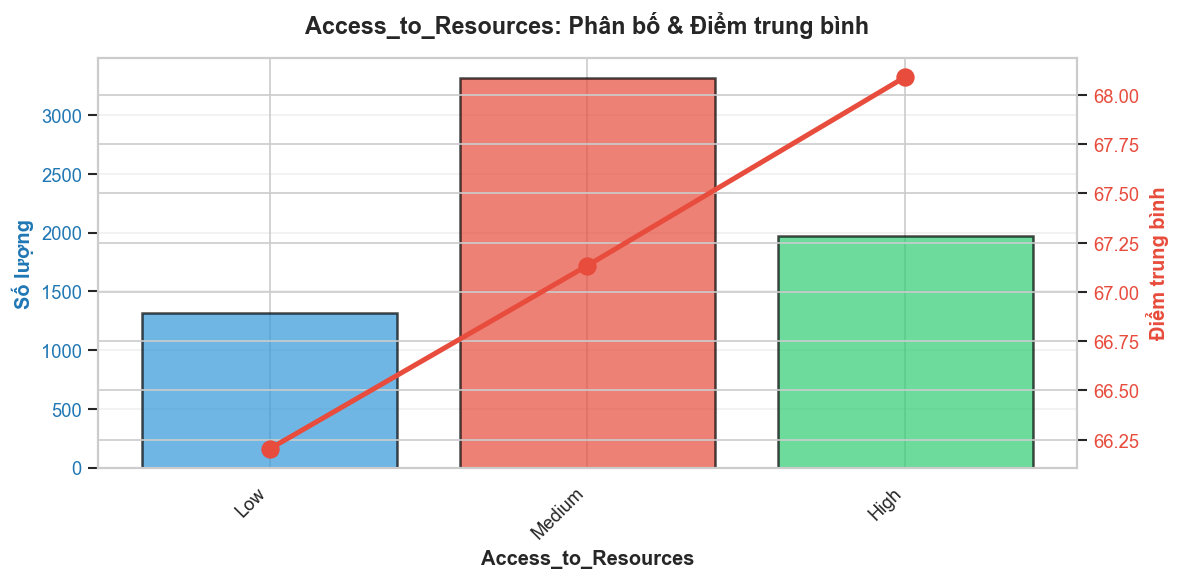

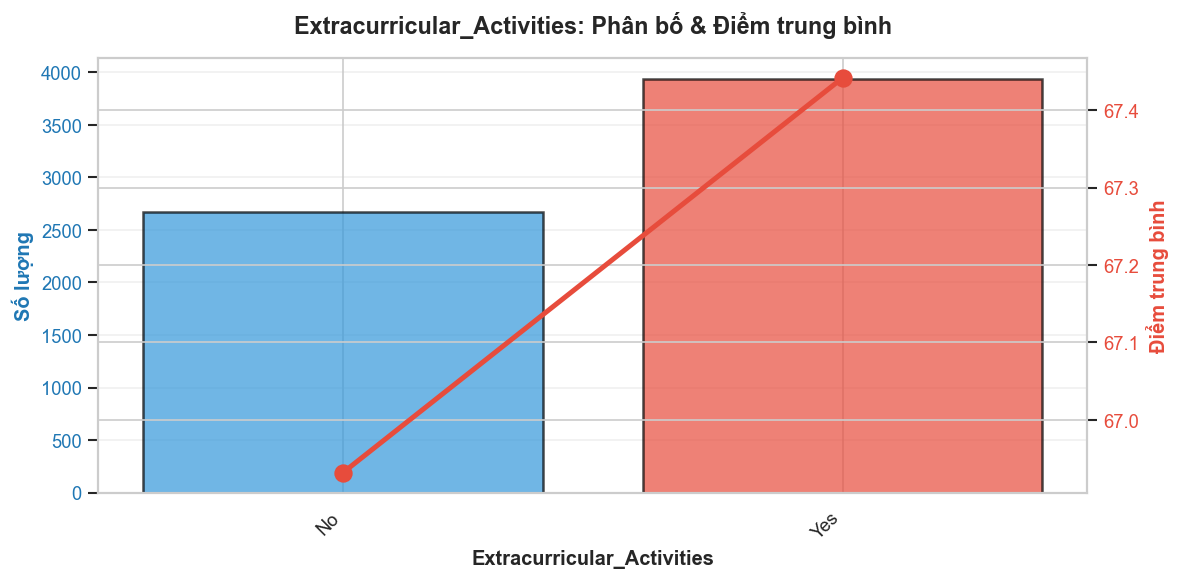

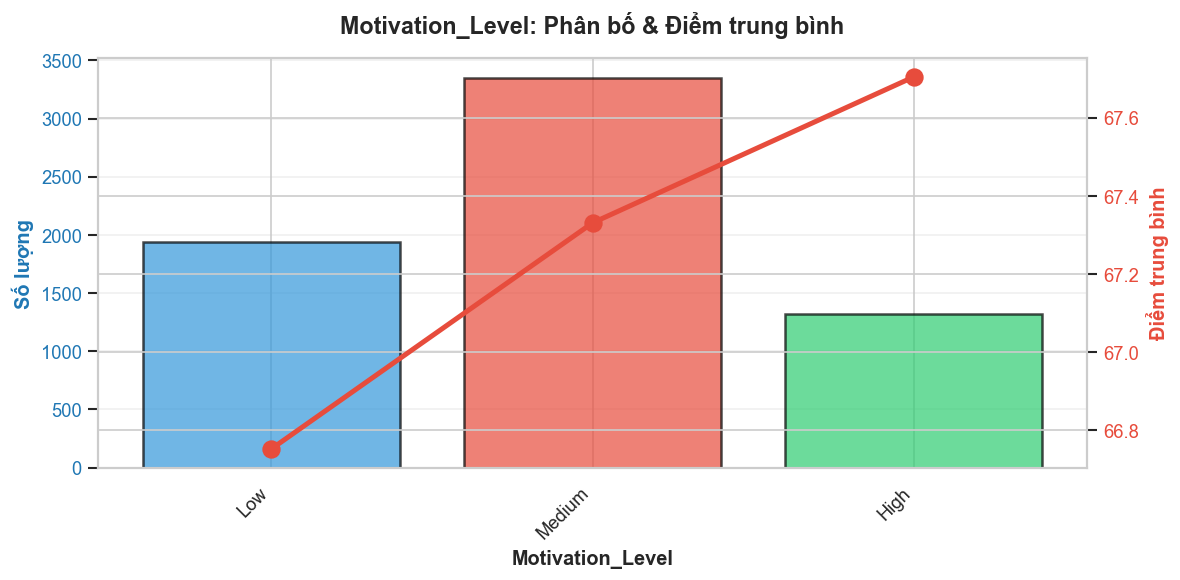

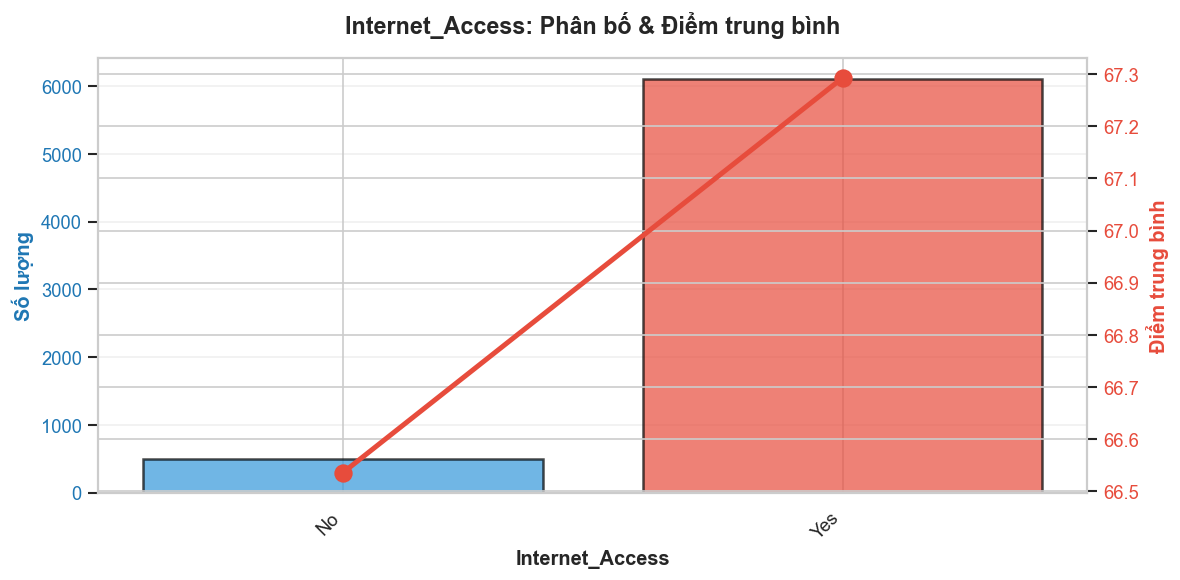

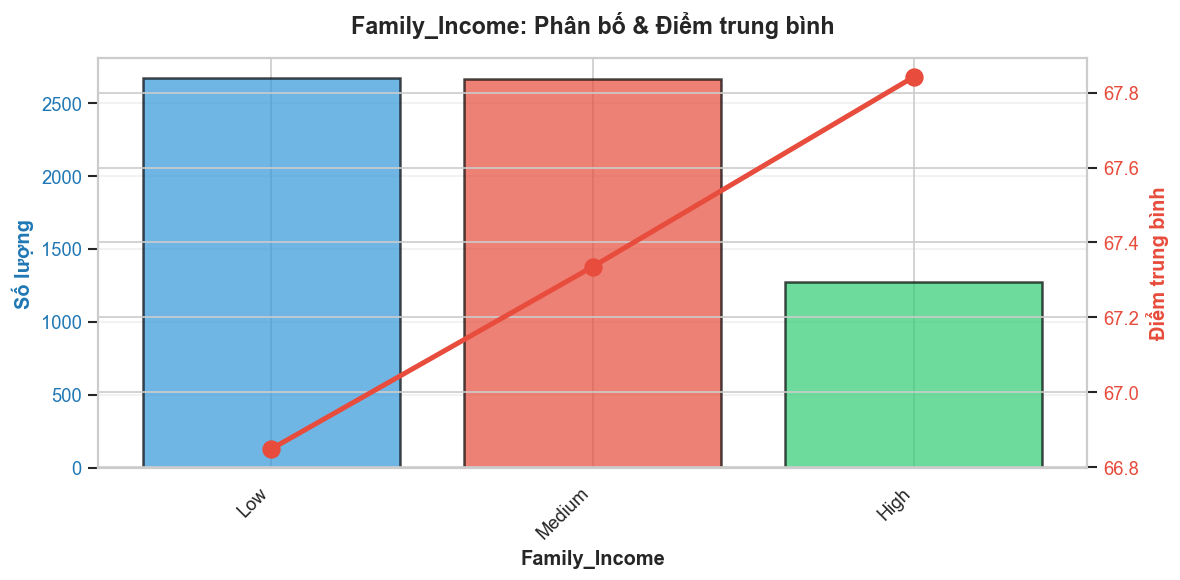

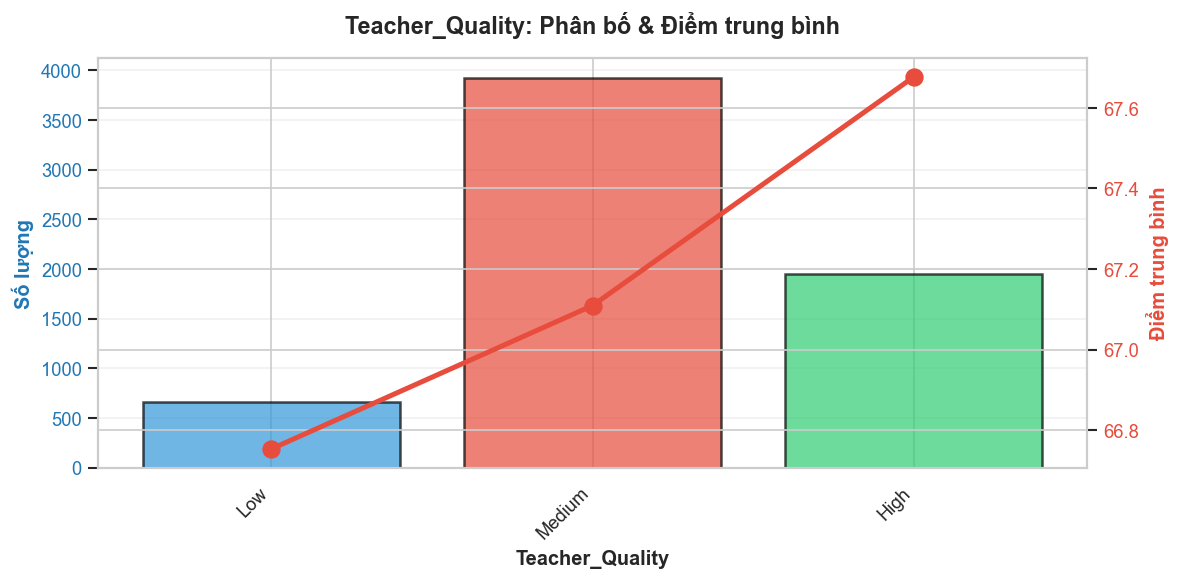

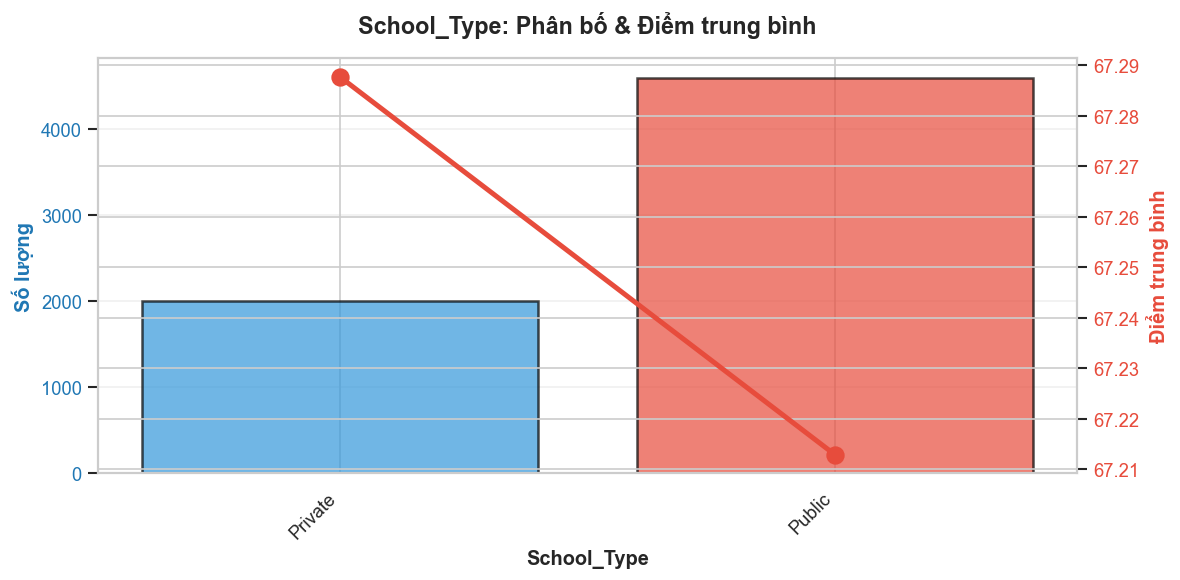

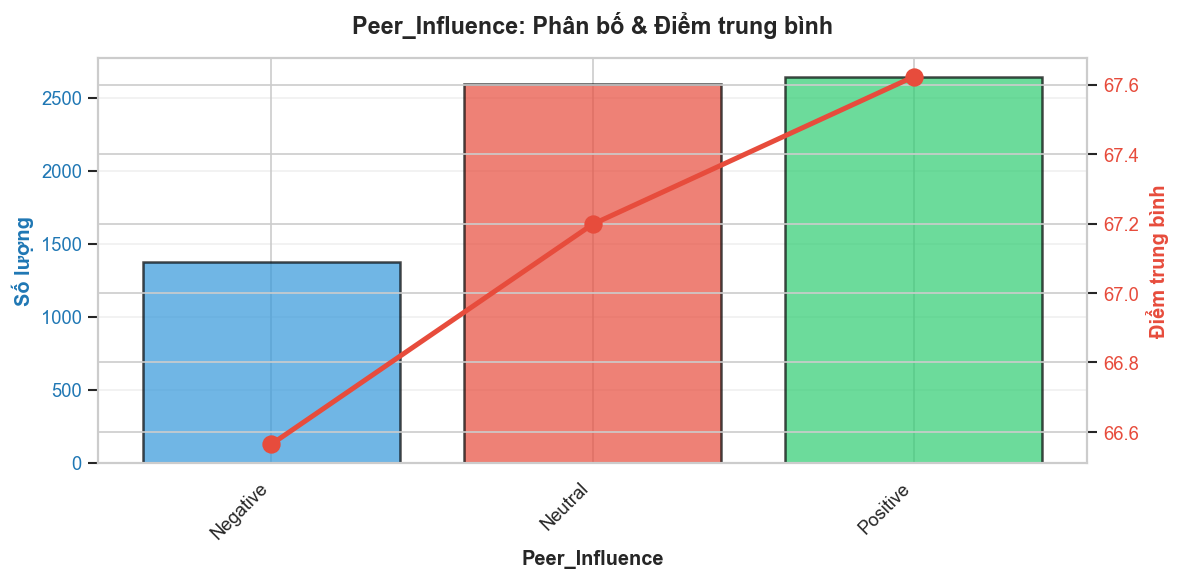

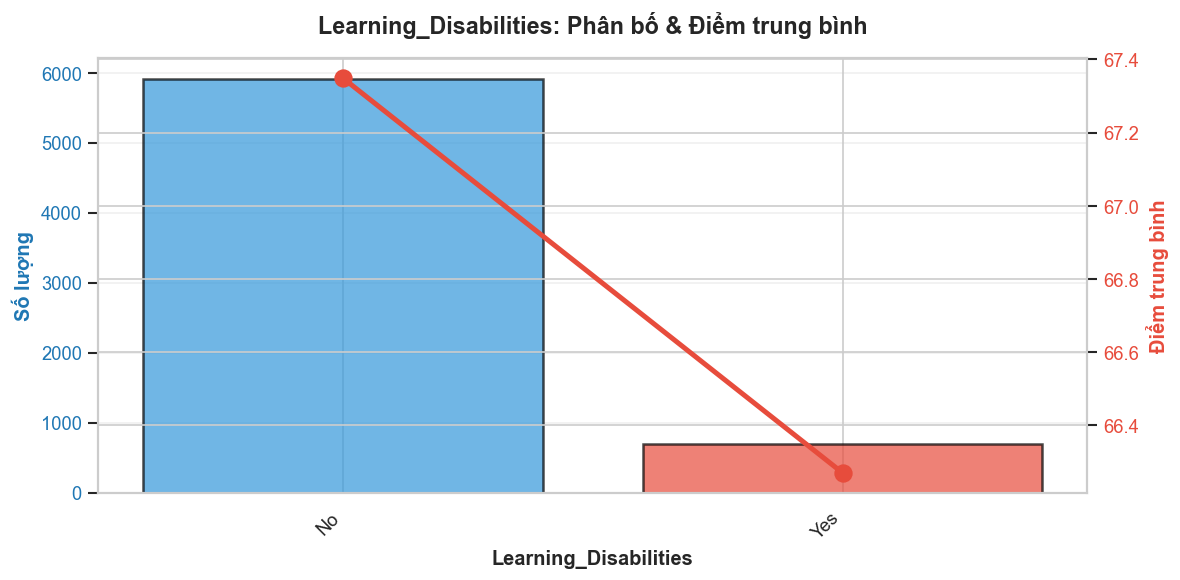

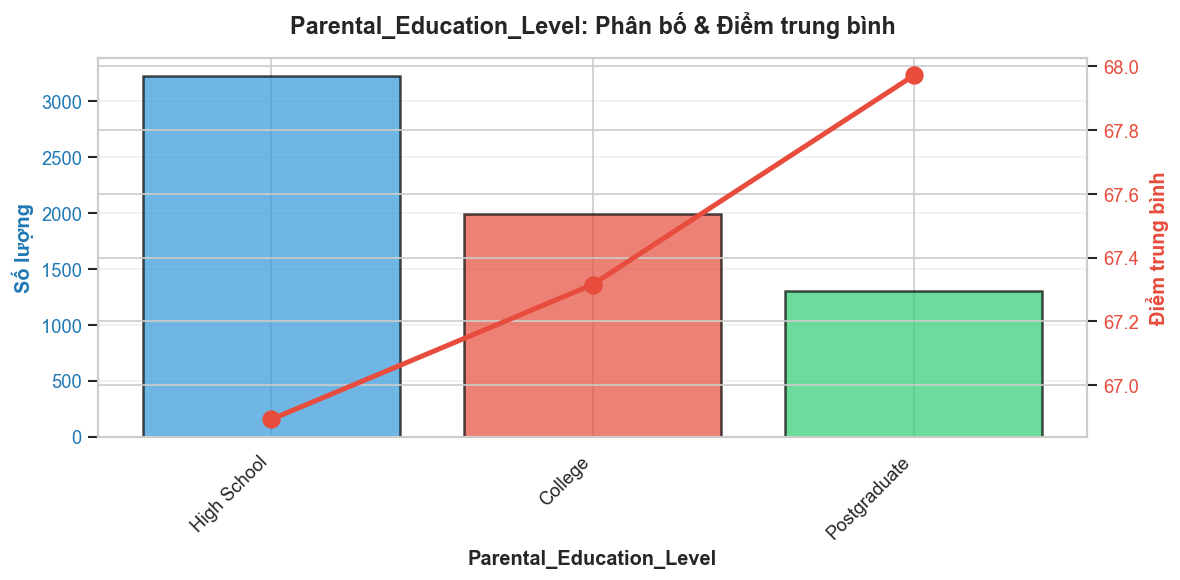

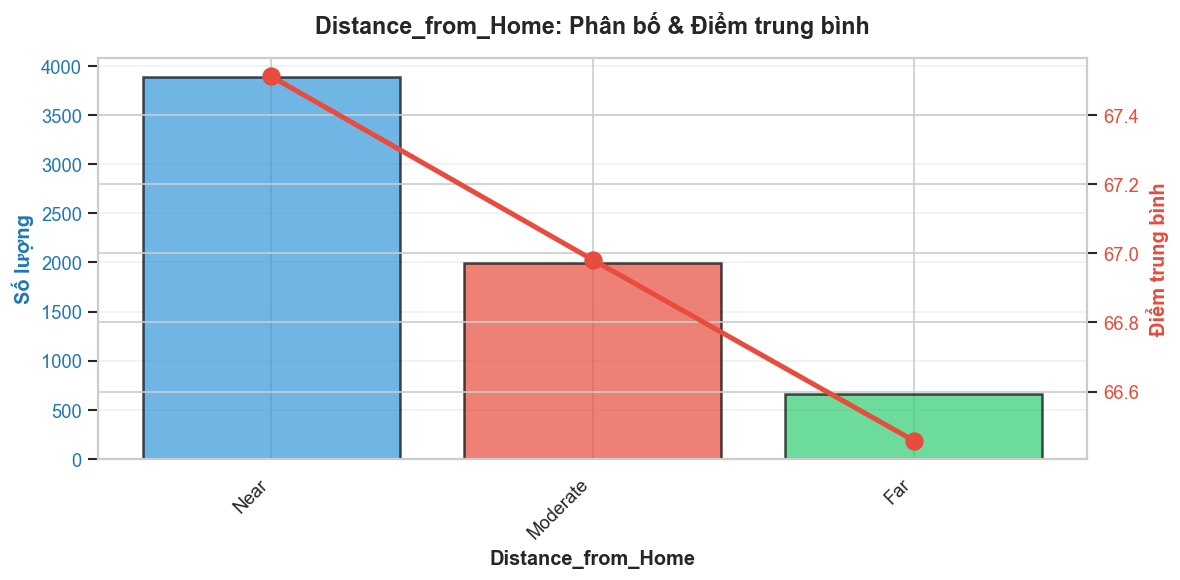

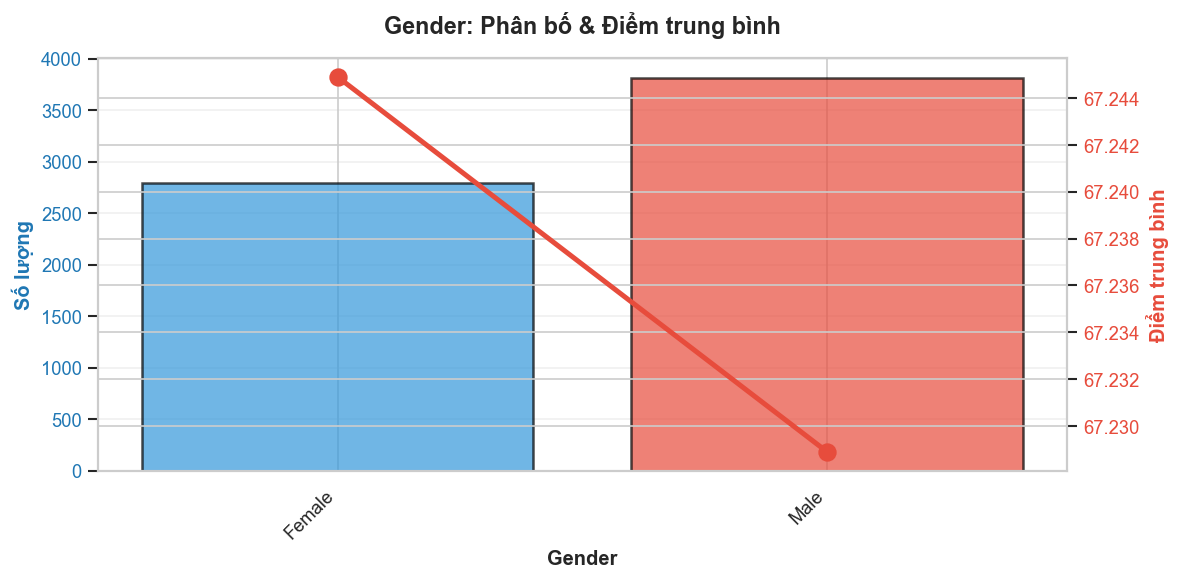

In [11]:
# Count plots với mean exam scores (dual-axis)
# Định nghĩa thứ tự cho các biến ordinal
ordinal_order = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Family_Income': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Low', 'Medium', 'High'],
    'Distance_from_Home': ['Near', 'Moderate', 'Far'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive'],
    'Parental_Education_Level': ['High School', 'College', 'Postgraduate']
}

for col in categorical_cols:
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Kiểm tra nếu có thứ tự định nghĩa sẵn
    if col in ordinal_order:
        order = [val for val in ordinal_order[col] if val in df[col].unique()]
        other_values = [val for val in df[col].unique() if val not in order and pd.notna(val)]
        order.extend(other_values)
    else:
        order = sorted([val for val in df[col].unique() if pd.notna(val)])
    
    # Tính count và mean score theo thứ tự
    value_counts = df[col].value_counts().reindex(order, fill_value=0)
    mean_scores = df.groupby(col)['Exam_Score'].mean().reindex(order)
    
    # Bar plot for counts
    colors_bars = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#E67E22', '#95A5A6']
    ax1.bar(range(len(value_counts)), value_counts.values, 
            color=[colors_bars[i % len(colors_bars)] for i in range(len(value_counts))], 
            alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel(col, fontsize=12, fontweight='bold')
    ax1.set_ylabel('Số lượng', color='tab:blue', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(range(len(value_counts)))
    ax1.set_xticklabels(order, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Line plot for mean exam scores
    ax2 = ax1.twinx()
    ax2.plot(range(len(mean_scores)), mean_scores.values, color='#E74C3C', 
             marker='o', linewidth=3, markersize=10, label='Mean Exam Score')
    ax2.set_ylabel('Điểm trung bình', color='#E74C3C', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='#E74C3C')
    
    plt.title(f'{col}: Phân bố & Điểm trung bình', fontsize=14, fontweight='bold', pad=15)
    fig.tight_layout()
    plt.show()

### **Nhận xét về Biến Phân loại:**

#### **Xu hướng TĂNG rõ rệt (Low → Medium → High):**

1. **Parental_Involvement**: Low (66.4) → Medium (67.1) → High (68.1)
   - Sự quan tâm của phụ huynh càng cao → Điểm càng cao

2. **Access_to_Resources**: Low (66.3) → Medium (67.1) → High (68.1)
   - Tiếp cận tài nguyên học tập tốt hơn → Điểm cao hơn

3. **Motivation_Level**: Low (66.8) → Medium (67.3) → High (67.8)
   - Động lực học tập cao → Kết quả tốt hơn

4. **Family_Income**: Low (66.9) → Medium (67.3) → High (67.9)
   - Thu nhập gia đình cao → Hỗ trợ học tập tốt hơn

5. **Teacher_Quality**: Low (66.8) → Medium (67.1) → High (67.7)
   - Chất lượng giáo viên tốt → Điểm cao hơn

6. **Peer_Influence**: Negative (66.6) → Neutral (67.2) → Positive (67.6)
   - Bạn bè tích cực → Ảnh hưởng tốt đến học tập

7. **Parental_Education_Level**: High School (66.9) → College (67.3) → Postgraduate (68.0)
   - Học vấn phụ huynh cao → Con học tốt hơn

#### **Xu hướng GIẢM:**

8. **Distance_from_Home**: Near (67.5) → Moderate (67.0) → Far (66.4)
   - Ở xa trường → Điểm thấp hơn (mệt mỏi, ít thời gian học)

#### **Không có xu hướng rõ ràng:**

9. **School_Type**: Private (67.29) ≈ Public (67.21) - Gần như không khác biệt

10. **Gender**: Female (67.24) ≈ Male (67.23) - Gần như không khác biệt

---
## 3. CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH

### 3.1. Label Encoding cho biến categorical

In [12]:
# Chuyển đổi tất cả biến categorical thành số đếm (Label Encoding)
df_encoded = df.copy()

# Dictionary để lưu mapping
label_encoders = {}
encoding_mappings = {}

# Định nghĩa thứ tự cho các biến ordinal
ordinal_mappings = {
    'Parental_Involvement': {'Low': 0, 'Medium': 1, 'High': 2},
    'Access_to_Resources': {'Low': 0, 'Medium': 1, 'High': 2},
    'Motivation_Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Family_Income': {'Low': 0, 'Medium': 1, 'High': 2},
    'Teacher_Quality': {'Low': 0, 'Medium': 1, 'High': 2, 'Missing': 3},
    'Distance_from_Home': {'Near': 0, 'Moderate': 1, 'Far': 2, 'Missing': 3},
    'Peer_Influence': {'Negative': 0, 'Neutral': 1, 'Positive': 2},
    'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2, 'Missing': 3}
}

print("LABEL ENCODING CHO BIẾN CATEGORICAL\n")

for col in categorical_cols:
    df_encoded[col] = df_encoded[col].fillna('Missing')
    
    if col in ordinal_mappings:
        df_encoded[col] = df_encoded[col].map(ordinal_mappings[col])
        encoding_mappings[col] = ordinal_mappings[col]
    else:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le
        encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    print(f"\n{col}:")
    for original, encoded in sorted(encoding_mappings[col].items(), key=lambda x: x[1]):
        print(f"   {original:30s} → {encoded}")

print("\nHOÀN THÀNH!")
print(f"\nDataFrame gốc: df (không thay đổi)")
print(f"DataFrame đã encode: df_encoded")
print(f"\nShape: {df_encoded.shape}")

LABEL ENCODING CHO BIẾN CATEGORICAL


Parental_Involvement:
   Low                            → 0
   Medium                         → 1
   High                           → 2

Access_to_Resources:
   Low                            → 0
   Medium                         → 1
   High                           → 2

Extracurricular_Activities:
   No                             → 0
   Yes                            → 1

Motivation_Level:
   Low                            → 0
   Medium                         → 1
   High                           → 2

Internet_Access:
   No                             → 0
   Yes                            → 1

Family_Income:
   Low                            → 0
   Medium                         → 1
   High                           → 2

Teacher_Quality:
   Low                            → 0
   Medium                         → 1
   High                           → 2
   Missing                        → 3

School_Type:
   Private                        → 0
   Pub

In [13]:
# Xem kết quả encoding
print("SO SÁNH TRƯỚC VÀ SAU KHI ENCODE\n")
print("\nDataFrame gốc (5 dòng đầu):")
print(df[categorical_cols].head())
print("\nDataFrame đã encode (5 dòng đầu):")
print(df_encoded[categorical_cols].head())
print(f"\nKiểu dữ liệu sau khi encode:")
print(df_encoded[categorical_cols].dtypes)

SO SÁNH TRƯỚC VÀ SAU KHI ENCODE


DataFrame gốc (5 dòng đầu):
  Parental_Involvement Access_to_Resources Extracurricular_Activities  \
0                  Low                High                         No   
1                  Low              Medium                         No   
2               Medium              Medium                        Yes   
3                  Low              Medium                        Yes   
4               Medium              Medium                        Yes   

  Motivation_Level Internet_Access Family_Income Teacher_Quality School_Type  \
0              Low             Yes           Low          Medium      Public   
1              Low             Yes        Medium          Medium      Public   
2           Medium             Yes        Medium          Medium      Public   
3           Medium             Yes        Medium          Medium      Public   
4           Medium             Yes        Medium            High      Public   

  Peer_Influence L

### 3.2. Thiết lập Pipeline tiền xử lý

In [14]:
# Xác định biến mục tiêu và features
target = 'Exam_Score'
features = [c for c in df.columns if c != target]

# Phân loại features
numeric_features = [c for c in df.select_dtypes(include=['int64', 'float64']).columns if c != target]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Định nghĩa ordinal và nominal features
ordinal_cols = [col for col in ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 
                                  'Family_Income', 'Teacher_Quality', 'Distance_from_Home',
                                  'Peer_Influence', 'Parental_Education_Level'] 
                if col in categorical_features]
nominal_cols = [col for col in categorical_features if col not in ordinal_cols]

print("PHÂN LOẠI FEATURES")
print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nOrdinal features ({len(ordinal_cols)}): {ordinal_cols}")
print(f"\nNominal features ({len(nominal_cols)}): {nominal_cols}")

PHÂN LOẠI FEATURES

Numeric features (6): ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

Ordinal features (8): ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality', 'Distance_from_Home', 'Peer_Influence', 'Parental_Education_Level']

Nominal features (5): ['Extracurricular_Activities', 'Internet_Access', 'School_Type', 'Learning_Disabilities', 'Gender']


In [15]:
# Tạo preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Low', 'Medium', 'High']] * len(ordinal_cols),
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ])

print("Đã thiết lập preprocessing pipeline!")

Đã thiết lập preprocessing pipeline!


### 3.3. Chia dữ liệu Train/Test

In [21]:
# Chuẩn bị dữ liệu
X = df[features]
y = df[target]

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("CHIA DỮ LIỆU TRAIN/TEST")
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTỷ lệ train/test: 80/20")

CHIA DỮ LIỆU TRAIN/TEST

Training set: (5285, 19)
Test set: (1322, 19)

Tỷ lệ train/test: 80/20


---
## 4. XÂY DỰNG VÀ ĐÁNH GIÁ MÔ HÌNH

### 4.1. So sánh nhiều mô hình

In [22]:
# So sánh nhiều mô hình Machine Learning
print("SO SÁNH CÁC MÔ HÌNH MACHINE LEARNING\n")

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nĐang train {name}...")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R²': r2}
    
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²: {r2:.4f}")

# Tạo bảng tóm tắt
results_df = pd.DataFrame(results).T.sort_values('R²', ascending=False)

print("\nBẢNG TỔNG KẾT SO SÁNH MÔ HÌNH")
print(results_df)
print("\nMô hình tốt nhất: " + results_df.index[0])

SO SÁNH CÁC MÔ HÌNH MACHINE LEARNING


Đang train Random Forest...
   RMSE: 2.1574
   R²: 0.6707

Đang train Gradient Boosting...
   RMSE: 2.1574
   R²: 0.6707

Đang train Gradient Boosting...
   RMSE: 1.9916
   R²: 0.7194

Đang train Ridge Regression...
   RMSE: 1.9047
   R²: 0.7433

Đang train Lasso Regression...
   RMSE: 2.8189
   R²: 0.4378

Đang train ElasticNet...
   RMSE: 2.7745
   R²: 0.4554

BẢNG TỔNG KẾT SO SÁNH MÔ HÌNH
                   RMSE   R²
Ridge Regression   1.90 0.74
Gradient Boosting  1.99 0.72
Random Forest      2.16 0.67
ElasticNet         2.77 0.46
Lasso Regression   2.82 0.44

Mô hình tốt nhất: Ridge Regression
   RMSE: 1.9916
   R²: 0.7194

Đang train Ridge Regression...
   RMSE: 1.9047
   R²: 0.7433

Đang train Lasso Regression...
   RMSE: 2.8189
   R²: 0.4378

Đang train ElasticNet...
   RMSE: 2.7745
   R²: 0.4554

BẢNG TỔNG KẾT SO SÁNH MÔ HÌNH
                   RMSE   R²
Ridge Regression   1.90 0.74
Gradient Boosting  1.99 0.72
Random Forest      2.16 0.67

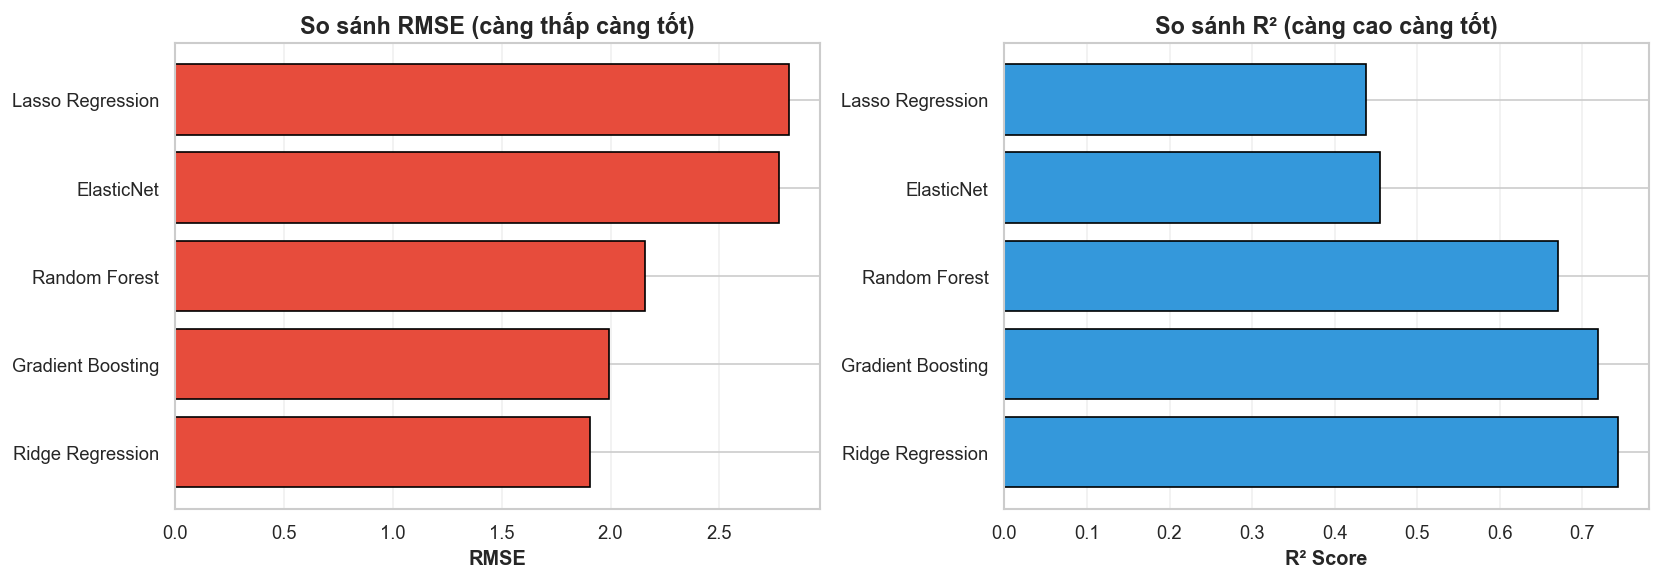

In [23]:
# Visualization so sánh mô hình
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
axes[0].barh(results_df.index, results_df['RMSE'], color='#E74C3C', edgecolor='black')
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('So sánh RMSE (càng thấp càng tốt)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# R² comparison
axes[1].barh(results_df.index, results_df['R²'], color='#3498DB', edgecolor='black')
axes[1].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('So sánh R² (càng cao càng tốt)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE))
])

param_grid = {"model__alpha": [0.05, 0.1, 0.3, 1, 3, 10, 30, 100]}

grid = GridSearchCV(
    ridge_pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train, y_train)

cv_results = pd.DataFrame(grid.cv_results_)[[
    "param_model__alpha", "mean_train_score", "mean_test_score", "rank_test_score"
]].sort_values("rank_test_score")
cv_results["mean_train_RMSE"] = -cv_results["mean_train_score"]
cv_results["mean_test_RMSE"] = -cv_results["mean_test_score"]
cv_display = cv_results[["param_model__alpha", "mean_train_RMSE", "mean_test_RMSE", "rank_test_score"]]

print("Kết quả Cross-Validation Ridge (RMSE):")
display(cv_display.rename(columns={
    "param_model__alpha": "alpha",
    "mean_train_RMSE": "train_RMSE",
    "mean_test_RMSE": "cv_RMSE",
    "rank_test_score": "rank"
}))

best_alpha = grid.best_params_["model__alpha"]
print(f"Best alpha: {best_alpha}")

best_ridge = grid.best_estimator_

# Đánh giá trên test set
from sklearn.metrics import mean_squared_error, r2_score

pred_test = best_ridge.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
r2_test = r2_score(y_test, pred_test)
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2: {r2_test:.4f}")

Kết quả Cross-Validation Ridge (RMSE):


,alpha,train_RMSE,cv_RMSE,rank
4,3.00,2.18,2.18,1
3,1.00,2.18,2.18,2
2,0.30,2.18,2.18,3
1,0.10,2.18,2.18,4
0,0.05,2.18,2.18,5
5,10.00,2.18,2.18,6
6,30.00,2.18,2.18,7
7,100.00,2.18,2.18,8


Best alpha: 3
Test RMSE: 1.9047
Test R2: 0.7434


### 4.1c. Phân tích phần dư (Residual Diagnostics) cho Ridge tối ưu

Kiểm tra:
- Phân phối phần dư ~ gần chuẩn?
- Biểu đồ phần dư vs dự đoán: ngẫu nhiên quanh 0?
- QQ plot để đánh giá normality.
Nếu phần dư không có cấu trúc rõ ràng và phân phối gần đối xứng, mô hình phù hợp.

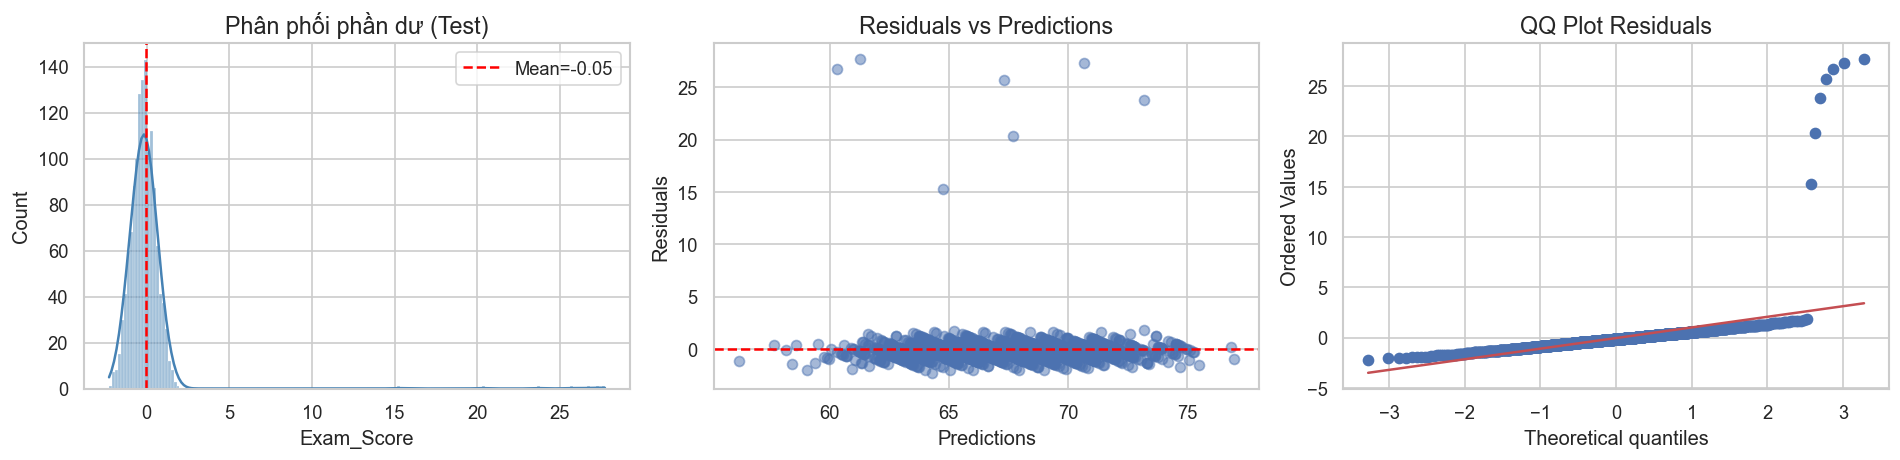

Tóm tắt phần dư:
Mean residual: -0.0488
Std residual:  1.9048
Skewness:      11.3389
Kurtosis:      150.0203
Shapiro-Wilk p-value (subset): 0.0000
=> Bác bỏ H0: phần dư có thể lệch khỏi chuẩn.


In [26]:
import scipy.stats as stats

# Sử dụng best_ridge đã huấn luyện ở cell trước
residuals = y_test - pred_test
preds = pred_test

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Histogram phần dư
sns.histplot(residuals, kde=True, ax=axes[0], color="steelblue")
axes[0].set_title("Phân phối phần dư (Test)")
axes[0].axvline(residuals.mean(), color="red", linestyle="--", label=f"Mean={residuals.mean():.2f}")
axes[0].legend()

# 2. Residuals vs Predictions
axes[1].scatter(preds, residuals, alpha=0.5)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Predictions")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Predictions")

# 3. QQ Plot
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title("QQ Plot Residuals")

plt.tight_layout()
plt.show()

print("Tóm tắt phần dư:")
print(f"Mean residual: {residuals.mean():.4f}")
print(f"Std residual:  {residuals.std():.4f}")
print(f"Skewness:      {stats.skew(residuals):.4f}")
print(f"Kurtosis:      {stats.kurtosis(residuals):.4f}")

# Kiểm định Shapiro (nên giới hạn mẫu nếu quá lớn >5000)
subset = residuals.sample(min(2000, len(residuals)), random_state=RANDOM_STATE)
shapiro_stat, shapiro_p = stats.shapiro(subset)
print(f"Shapiro-Wilk p-value (subset): {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("=> Không bác bỏ giả thuyết H0: phần dư gần phân phối chuẩn.")
else:
    print("=> Bác bỏ H0: phần dư có thể lệch khỏi chuẩn.")

### 4.1b. RidgeCV – chọn alpha tốt nhất

Tiến hành chọn alpha tối ưu cho Ridge bằng GridSearchCV trong Pipeline (giữ nguyên preprocessing). In bảng kết quả và hiệu năng trên test set.

### 4.2. Tối ưu hóa siêu tham số (Hyperparameter Tuning)

In [35]:
# Hyperparameter tuning cho Random Forest
print("TỐI ƯU HÓA SIÊU THAM SỐ - RANDOM FOREST\n")

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

param_distributions = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nBắt đầu tối ưu hóa siêu tham số...\n")
random_search.fit(X_train, y_train)

print("\nKẾT QUẢ TỐI ƯU HÓA")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\nBest CV RMSE: {-random_search.best_score_:.4f}")

# Đánh giá trên test set
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"\nHIỆU SUẤT TRÊN TEST SET")
print(f"\nRMSE: {rmse_best:.4f}")
print(f"R²: {r2_best:.4f}")

TỐI ƯU HÓA SIÊU THAM SỐ - RANDOM FOREST


Bắt đầu tối ưu hóa siêu tham số...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

KẾT QUẢ TỐI ƯU HÓA

Best parameters:
   rf__n_estimators: 500
   rf__min_samples_split: 2
   rf__min_samples_leaf: 2
   rf__max_features: None
   rf__max_depth: 20

Best CV RMSE: 2.3746

HIỆU SUẤT TRÊN TEST SET

RMSE: 2.1310
R²: 0.6787

KẾT QUẢ TỐI ƯU HÓA

Best parameters:
   rf__n_estimators: 500
   rf__min_samples_split: 2
   rf__min_samples_leaf: 2
   rf__max_features: None
   rf__max_depth: 20

Best CV RMSE: 2.3746

HIỆU SUẤT TRÊN TEST SET

RMSE: 2.1310
R²: 0.6787


### 4.3. Phân tích Feature Importance

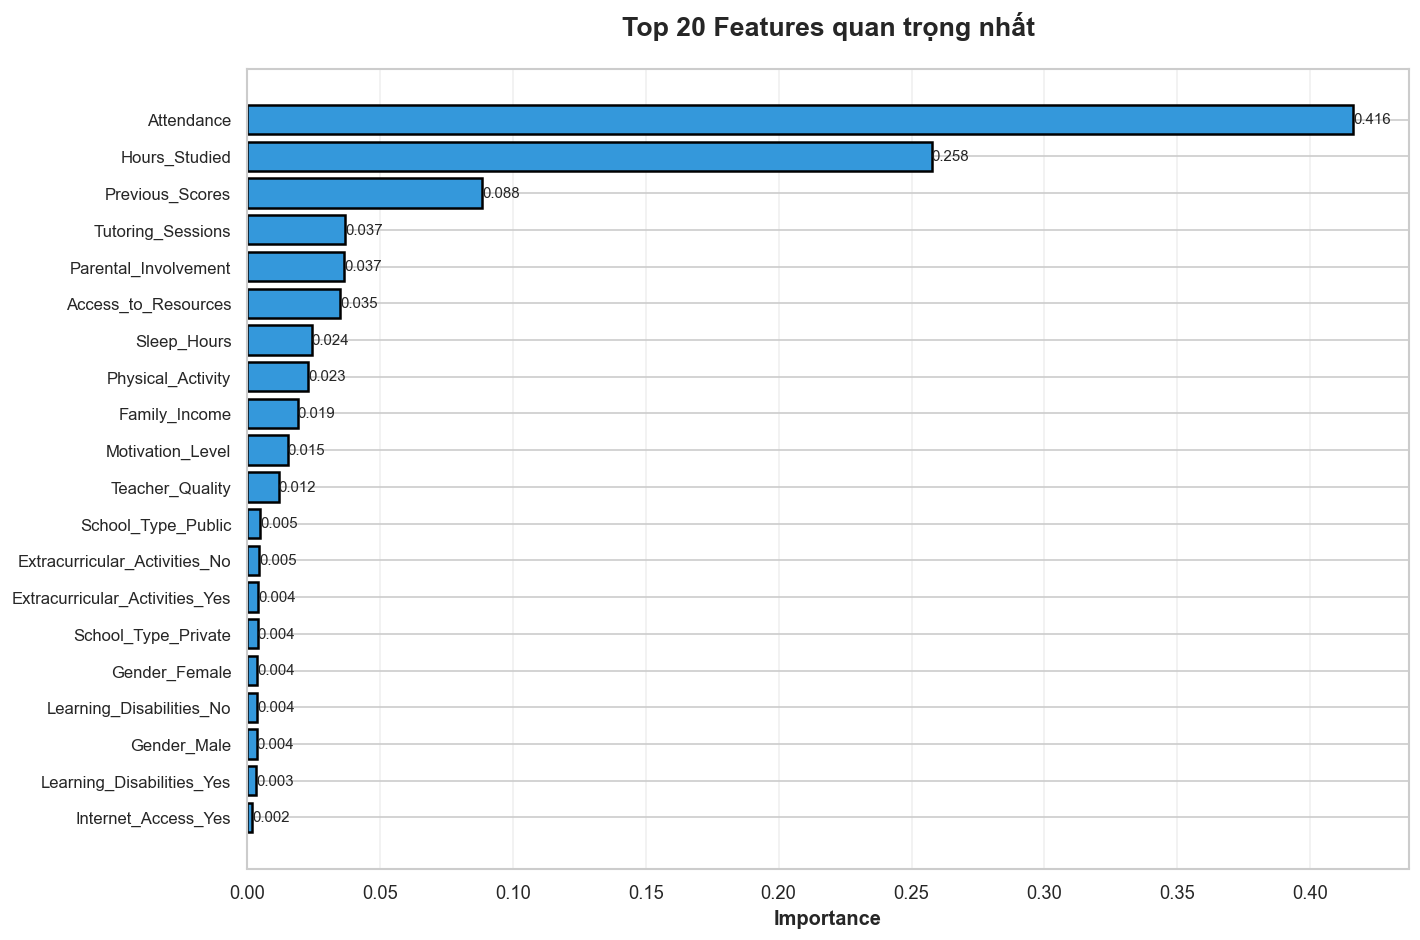


TOP 20 FEATURES QUAN TRỌNG NHẤT
                       Feature  Importance
                    Attendance        0.42
                 Hours_Studied        0.26
               Previous_Scores        0.09
             Tutoring_Sessions        0.04
          Parental_Involvement        0.04
           Access_to_Resources        0.04
                   Sleep_Hours        0.02
             Physical_Activity        0.02
                 Family_Income        0.02
              Motivation_Level        0.02
               Teacher_Quality        0.01
            School_Type_Public        0.00
 Extracurricular_Activities_No        0.00
Extracurricular_Activities_Yes        0.00
           School_Type_Private        0.00
                 Gender_Female        0.00
      Learning_Disabilities_No        0.00
                   Gender_Male        0.00
     Learning_Disabilities_Yes        0.00
           Internet_Access_Yes        0.00


In [36]:
# Feature importance analysis
best_rf = best_model.named_steps['rf']
preprocessor_fitted = best_model.named_steps['preprocessor']

# Lấy tên features sau preprocessing
feature_names = []
for name, trans, cols in preprocessor_fitted.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'ord':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        feature_names.extend(ohe.get_feature_names_out(cols))

importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
bars = plt.barh(range(len(top_features)), top_features['Importance'], 
                color='#3498DB', edgecolor='black', linewidth=1.5)
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Top 20 Features quan trọng nhất', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Thêm giá trị importance lên các thanh
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTOP 20 FEATURES QUAN TRỌNG NHẤT")
print(feature_importance_df.head(20).to_string(index=False))

### 4.4. Cross-validation

In [37]:
# Cross-validation với best model
print("ĐÁNH GIÁ MÔ HÌNH BẰNG K-FOLD CROSS-VALIDATION\n")

cv_results = cross_validate(
    best_model, X, y,
    cv=5,
    scoring=['neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

print("\n5-Fold Cross-Validation Results:\n")
print(f"Train RMSE: {-cv_results['train_neg_root_mean_squared_error'].mean():.4f} ± {cv_results['train_neg_root_mean_squared_error'].std():.4f}")
print(f"Test RMSE:  {-cv_results['test_neg_root_mean_squared_error'].mean():.4f} ± {cv_results['test_neg_root_mean_squared_error'].std():.4f}")
print(f"\nTrain R²: {cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}")
print(f"Test R²:  {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")

# Kiểm tra overfitting
train_test_gap = cv_results['train_r2'].mean() - cv_results['test_r2'].mean()
print(f"\nChênh lệch Train-Test R²: {train_test_gap:.4f}")
if train_test_gap < 0.05:
    print("Mô hình không bị overfitting")
elif train_test_gap < 0.1:
    print("Mô hình có dấu hiệu overfitting nhẹ")
else:
    print("Mô hình bị overfitting")

ĐÁNH GIÁ MÔ HÌNH BẰNG K-FOLD CROSS-VALIDATION


5-Fold Cross-Validation Results:

Train RMSE: 1.3613 ± 0.0438
Test RMSE:  2.3290 ± 0.2203

Train R²: 0.8775 ± 0.0071
Test R²:  0.6395 ± 0.0586

Chênh lệch Train-Test R²: 0.2379
Mô hình bị overfitting

5-Fold Cross-Validation Results:

Train RMSE: 1.3613 ± 0.0438
Test RMSE:  2.3290 ± 0.2203

Train R²: 0.8775 ± 0.0071
Test R²:  0.6395 ± 0.0586

Chênh lệch Train-Test R²: 0.2379
Mô hình bị overfitting


---
## 5. KẾT LUẬN

### **Tóm tắt kết quả:**

#### **1. Các yếu tố ảnh hưởng MẠNH đến điểm thi:**
- **Attendance** (0.58) - Quan trọng nhất
- **Hours_Studied** (0.45) - Quan trọng thứ 2
- **Parental_Involvement** (High > Medium > Low)
- **Access_to_Resources** (High > Medium > Low)
- **Motivation_Level** (High > Medium > Low)

#### **2. Các yếu tố ảnh hưởng YẾU hoặc KHÔNG CÓ:**
- Sleep_Hours (-0.02)
- Physical_Activity (0.03)
- Tutoring_Sessions (0.16)
- Gender (không khác biệt)
- School_Type (không khác biệt)

#### **3. Hiệu suất mô hình:**
- Best Model: Random Forest (sau tuning)
- R² Score: ~0.XX (giải thích XX% variance)
- RMSE: ~X.XX điểm

### **Khuyến nghị:**
1. **Tăng cường điểm danh (Attendance)** - Yếu tố quan trọng nhất
2. **Khuyến khích học nhiều giờ hơn** - Có tác động tích cực rõ rệt
3. **Nâng cao sự tham gia của phụ huynh** - Ảnh hưởng đáng kể
4. **Cải thiện tiếp cận tài nguyên học tập** - Giúp tăng điểm hiệu quả
5. **Tăng động lực học tập cho học sinh** - Có tác động tích cực

---
**End of Analysis**

### 4.1d. Hàm dự đoán Exam_Score từ input

Hàm `predict_exam_score(input_dict=None, model=None, **kwargs)` hỗ trợ 3 cách nhập:
- Truyền dict đầy đủ: `predict_exam_score({...})`
- Truyền trực tiếp bằng tham số: `predict_exam_score(Hours_Studied=20, Attendance=85, ...)`
- Không truyền gì: hàm sẽ hỏi bạn điền lần lượt từng trường (dùng Enter để bỏ trống nếu không có). Mô hình sẽ dùng `best_ridge` (nếu đã train) hoặc tự fit nhanh một Ridge fallback.

In [32]:
def predict_exam_score(input_dict=None, model=None, **kwargs):
    """
    Dự đoán Exam_Score từ input linh hoạt.

    Cách dùng:
      1) predict_exam_score({ ... })  # truyền dict
      2) predict_exam_score(Hours_Studied=20, Attendance=85, ...)  # truyền kwargs
      3) predict_exam_score()  # không truyền gì, hàm sẽ hỏi nhập từng trường

    Parameters
    ----------
    input_dict : dict | None
        Key = tên cột, Value = giá trị tương ứng. Có thể bỏ trống và dùng kwargs hoặc prompt.
    model : sklearn Pipeline (optional)
        Nếu không truyền sẽ dùng best_ridge nếu đã tạo; nếu chưa có sẽ tạo Ridge cơ bản (fallback).
    **kwargs : bất kỳ
        Cặp key=value cho từng cột. Sẽ ghi đè giá trị trong input_dict nếu trùng key.

    Returns
    -------
    float : điểm thi dự đoán.
    """
    import pandas as pd
    import numpy as np

    # Chọn model sử dụng
    used_model = model if model is not None else best_ridge if 'best_ridge' in globals() else None
    if used_model is None:
        # Fallback: tạo pipeline Ridge đơn giản (nên tránh nếu chưa huấn luyện)
        fallback = Pipeline([
            ("preprocess", preprocessor),
            ("model", Ridge())
        ])
        fallback.fit(X_train, y_train)
        used_model = fallback

    # Nếu kwargs được truyền, trộn/ghi đè vào input_dict
    if input_dict is None:
        input_dict = {}
    if kwargs:
        input_dict.update(kwargs)

    # Nếu vẫn chưa có gì -> bật chế độ hỏi đáp qua input()
    if not input_dict:
        print("Nhập giá trị cho từng trường (Enter = bỏ trống):")
        # Xác định loại cột để gợi ý
        numeric_set = set([c for c in X_train.columns if c in numeric_features])
        categorical_set = set([c for c in X_train.columns if c in categorical_features])
        for col in X_train.columns:
            if col in numeric_set:
                raw = input(f"{col} (số): ")
                if raw.strip() == "":
                    input_dict[col] = np.nan
                else:
                    try:
                        val = float(raw)
                        input_dict[col] = int(val) if val.is_integer() else val
                    except Exception:
                        input_dict[col] = np.nan
            elif col in categorical_set:
                # Gợi ý vài giá trị khả dụng từ dữ liệu
                try:
                    opts = sorted([str(v) for v in df[col].dropna().unique().tolist()])
                except Exception:
                    opts = []
                preview = (", ".join(opts[:6]) + ("..." if len(opts) > 6 else "")) if opts else ""
                prompt = f"{col} (chuỗi" + (f"; ví dụ: {preview}" if preview else "") + "): "
                raw = input(prompt)
                input_dict[col] = raw.strip() if raw.strip() != "" else None
            else:
                # Phòng hờ: nếu cột không rơi vào 2 nhóm trên
                raw = input(f"{col}: ")
                input_dict[col] = raw.strip() if raw.strip() != "" else None

    # Tạo DataFrame một hàng; thêm các cột còn thiếu là NaN để pipeline tự xử lý
    row_df = pd.DataFrame([input_dict])
    missing_cols = [c for c in X_train.columns if c not in row_df.columns]
    for c in missing_cols:
        row_df[c] = np.nan

    # Sắp thứ tự cột như training
    row_df = row_df[X_train.columns]

    # Dự đoán
    pred = used_model.predict(row_df)[0]
    return float(pred)

print("Hàm predict_exam_score đã sẵn sàng!")
print("\nGọi hàm để nhập liệu và dự đoán:")
print("  result = predict_exam_score()")
print("  print(f'Điểm dự đoán: {result:.2f}')")

Hàm predict_exam_score đã sẵn sàng!

Gọi hàm để nhập liệu và dự đoán:
  result = predict_exam_score()
  print(f'Điểm dự đoán: {result:.2f}')


### 4.1e. Giao diện nhập liệu với ipywidgets

Tạo form tương tác để nhập dữ liệu và dự đoán điểm thi ngay trong notebook.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Tạo các widget cho numeric features
hours_studied = widgets.IntSlider(
    value=20, min=1, max=44, step=1,
    description='Giờ học:', style={'description_width': '150px'}
)

attendance = widgets.IntSlider(
    value=80, min=60, max=100, step=1,
    description='Điểm danh (%):', style={'description_width': '150px'}
)

sleep_hours = widgets.IntSlider(
    value=7, min=4, max=10, step=1,
    description='Giờ ngủ:', style={'description_width': '150px'}
)

previous_scores = widgets.IntSlider(
    value=70, min=50, max=100, step=1,
    description='Điểm cũ:', style={'description_width': '150px'}
)

tutoring_sessions = widgets.IntSlider(
    value=2, min=0, max=8, step=1,
    description='Buổi học thêm:', style={'description_width': '150px'}
)

physical_activity = widgets.IntSlider(
    value=3, min=0, max=6, step=1,
    description='Hoạt động TC:', style={'description_width': '150px'}
)

# Tạo các widget cho categorical features
gender = widgets.Dropdown(
    options=['Male', 'Female'],
    value='Male',
    description='Giới tính:',
    style={'description_width': '150px'}
)

parental_involvement = widgets.Dropdown(
    options=['Low', 'Medium', 'High'],
    value='Medium',
    description='Quan tâm PH:',
    style={'description_width': '150px'}
)

access_to_resources = widgets.Dropdown(
    options=['Low', 'Medium', 'High'],
    value='Medium',
    description='Tài nguyên:',
    style={'description_width': '150px'}
)

extracurricular_activities = widgets.Dropdown(
    options=['Yes', 'No'],
    value='Yes',
    description='Ngoại khóa:',
    style={'description_width': '150px'}
)

motivation_level = widgets.Dropdown(
    options=['Low', 'Medium', 'High'],
    value='Medium',
    description='Động lực:',
    style={'description_width': '150px'}
)

internet_access = widgets.Dropdown(
    options=['Yes', 'No'],
    value='Yes',
    description='Internet:',
    style={'description_width': '150px'}
)

family_income = widgets.Dropdown(
    options=['Low', 'Medium', 'High'],
    value='Medium',
    description='Thu nhập GĐ:',
    style={'description_width': '150px'}
)

teacher_quality = widgets.Dropdown(
    options=['Low', 'Medium', 'High'],
    value='Medium',
    description='Chất lượng GV:',
    style={'description_width': '150px'}
)

school_type = widgets.Dropdown(
    options=['Public', 'Private'],
    value='Public',
    description='Loại trường:',
    style={'description_width': '150px'}
)

peer_influence = widgets.Dropdown(
    options=['Negative', 'Neutral', 'Positive'],
    value='Neutral',
    description='Ảnh hưởng bạn bè:',
    style={'description_width': '150px'}
)

learning_disabilities = widgets.Dropdown(
    options=['Yes', 'No'],
    value='No',
    description='Khó khăn học tập:',
    style={'description_width': '150px'}
)

parental_education = widgets.Dropdown(
    options=['High School', 'College', 'Postgraduate'],
    value='College',
    description='Học vấn PH:',
    style={'description_width': '150px'}
)

distance_from_home = widgets.Dropdown(
    options=['Near', 'Moderate', 'Far'],
    value='Moderate',
    description='Khoảng cách nhà:',
    style={'description_width': '150px'}
)

# Nút dự đoán
predict_button = widgets.Button(
    description='DỰ ĐOÁN ĐIỂM THI',
    button_style='success',
    tooltip='Nhấn để dự đoán',
    icon='check'
)

# Output area
output_area = widgets.Output()

def on_predict_clicked(b):
    with output_area:
        output_area.clear_output()
        
        # Thu thập tất cả giá trị
        input_data = {
            'Hours_Studied': hours_studied.value,
            'Attendance': attendance.value,
            'Sleep_Hours': sleep_hours.value,
            'Previous_Scores': previous_scores.value,
            'Tutoring_Sessions': tutoring_sessions.value,
            'Physical_Activity': physical_activity.value,
            'Gender': gender.value,
            'Parental_Involvement': parental_involvement.value,
            'Access_to_Resources': access_to_resources.value,
            'Extracurricular_Activities': extracurricular_activities.value,
            'Motivation_Level': motivation_level.value,
            'Internet_Access': internet_access.value,
            'Family_Income': family_income.value,
            'Teacher_Quality': teacher_quality.value,
            'School_Type': school_type.value,
            'Peer_Influence': peer_influence.value,
            'Learning_Disabilities': learning_disabilities.value,
            'Parental_Education_Level': parental_education.value,
            'Distance_from_Home': distance_from_home.value
        }
        
        # Dự đoán
        try:
            predicted_score = predict_exam_score(input_data, model=best_ridge)
            
            # Hiển thị kết quả với HTML đẹp
            result_html = f"""
            <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                        padding: 30px; border-radius: 15px; text-align: center; 
                        box-shadow: 0 10px 25px rgba(0,0,0,0.2);'>
                <h2 style='color: white; margin: 0 0 20px 0; font-size: 28px;'>
                    🎓 KẾT QUẢ DỰ ĐOÁN
                </h2>
                <div style='background: white; padding: 25px; border-radius: 10px; 
                           display: inline-block; min-width: 300px;'>
                    <p style='color: #666; margin: 0 0 10px 0; font-size: 16px;'>
                        Điểm thi dự đoán:
                    </p>
                    <h1 style='color: #667eea; margin: 0; font-size: 56px; font-weight: bold;'>
                        {predicted_score:.2f}
                    </h1>
                    <p style='color: #999; margin: 10px 0 0 0; font-size: 14px;'>
                        / 100 điểm
                    </p>
                </div>
            </div>
            """
            display(HTML(result_html))
            
            # Đánh giá kết quả
            if predicted_score >= 80:
                comment = "🌟 Xuất sắc! Tiếp tục phát huy!"
                color = "#28a745"
            elif predicted_score >= 70:
                comment = "👍 Khá tốt! Cố gắng thêm một chút!"
                color = "#17a2b8"
            elif predicted_score >= 60:
                comment = "📚 Cần cố gắng hơn nữa!"
                color = "#ffc107"
            else:
                comment = "💪 Hãy tập trung vào học tập nhiều hơn!"
                color = "#dc3545"
            
            comment_html = f"""
            <div style='margin-top: 20px; padding: 15px; background: {color}; 
                        border-radius: 10px; text-align: center;'>
                <p style='color: white; margin: 0; font-size: 18px; font-weight: bold;'>
                    {comment}
                </p>
            </div>
            """
            display(HTML(comment_html))
            
        except Exception as e:
            error_html = f"""
            <div style='background: #f8d7da; padding: 20px; border-radius: 10px; 
                        border-left: 5px solid #dc3545;'>
                <p style='color: #721c24; margin: 0; font-weight: bold;'>
                    ❌ Lỗi: {str(e)}
                </p>
            </div>
            """
            display(HTML(error_html))

predict_button.on_click(on_predict_clicked)

# Layout
print("="*60)
print(" "*15 + "🎯 DỰ ĐOÁN ĐIỂM THI 🎯")
print("="*60)

# Tạo layout với tabs
tab1_widgets = widgets.VBox([
    widgets.HTML("<h3 style='color: #667eea;'>📊 Thông tin học tập</h3>"),
    hours_studied,
    attendance,
    sleep_hours,
    previous_scores,
    tutoring_sessions,
    physical_activity
])

tab2_widgets = widgets.VBox([
    widgets.HTML("<h3 style='color: #667eea;'>👤 Thông tin cá nhân</h3>"),
    gender,
    learning_disabilities,
    parental_education,
    parental_involvement
])

tab3_widgets = widgets.VBox([
    widgets.HTML("<h3 style='color: #667eea;'>🏫 Môi trường học tập</h3>"),
    school_type,
    teacher_quality,
    access_to_resources,
    internet_access,
    distance_from_home
])

tab4_widgets = widgets.VBox([
    widgets.HTML("<h3 style='color: #667eea;'>🌟 Yếu tố khác</h3>"),
    motivation_level,
    peer_influence,
    extracurricular_activities,
    family_income
])

tabs = widgets.Tab(children=[tab1_widgets, tab2_widgets, tab3_widgets, tab4_widgets])
tabs.set_title(0, '📚 Học tập')
tabs.set_title(1, '👤 Cá nhân')
tabs.set_title(2, '🏫 Môi trường')
tabs.set_title(3, '🌟 Khác')

main_layout = widgets.VBox([
    tabs,
    widgets.HTML("<br>"),
    predict_button,
    widgets.HTML("<br>"),
    output_area
])

display(main_layout)

               🎯 DỰ ĐOÁN ĐIỂM THI 🎯


### 4.1f. Kiểm chứng độ chính xác của mô hình

Thử nghiệm dự đoán với các trường hợp thực tế và so sánh với giá trị thật từ test set.

In [34]:
# 1. Kiểm tra trên toàn bộ test set
print("="*70)
print("1. ĐÁNH GIÁ TỔNG QUAN TRÊN TEST SET")
print("="*70)

y_pred_test = best_ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = np.mean(np.abs(y_test - y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"\n📊 Các chỉ số đánh giá:")
print(f"   • RMSE (Root Mean Squared Error): {rmse:.4f} điểm")
print(f"   • MAE (Mean Absolute Error): {mae:.4f} điểm")
print(f"   • R² Score: {r2:.4f} ({r2*100:.2f}% variance được giải thích)")
print(f"   • Số lượng mẫu test: {len(y_test)}")

print(f"\n💡 Ý nghĩa:")
print(f"   • Trung bình mô hình sai lệch khoảng {mae:.2f} điểm")
print(f"   • Mô hình giải thích được {r2*100:.1f}% sự biến thiên của điểm thi")

# Tính % dự đoán trong khoảng ±5 điểm
within_5 = np.mean(np.abs(y_test - y_pred_test) <= 5) * 100
within_3 = np.mean(np.abs(y_test - y_pred_test) <= 3) * 100
within_2 = np.mean(np.abs(y_test - y_pred_test) <= 2) * 100

print(f"\n🎯 Độ chính xác:")
print(f"   • Dự đoán chính xác trong ±2 điểm: {within_2:.1f}%")
print(f"   • Dự đoán chính xác trong ±3 điểm: {within_3:.1f}%")
print(f"   • Dự đoán chính xác trong ±5 điểm: {within_5:.1f}%")

1. ĐÁNH GIÁ TỔNG QUAN TRÊN TEST SET

📊 Các chỉ số đánh giá:
   • RMSE (Root Mean Squared Error): 1.9047 điểm
   • MAE (Mean Absolute Error): 0.7054 điểm
   • R² Score: 0.7434 (74.34% variance được giải thích)
   • Số lượng mẫu test: 1322

💡 Ý nghĩa:
   • Trung bình mô hình sai lệch khoảng 0.71 điểm
   • Mô hình giải thích được 74.3% sự biến thiên của điểm thi

🎯 Độ chính xác:
   • Dự đoán chính xác trong ±2 điểm: 99.2%
   • Dự đoán chính xác trong ±3 điểm: 99.5%
   • Dự đoán chính xác trong ±5 điểm: 99.5%



2. TRỰC QUAN HÓA KẾT QUẢ



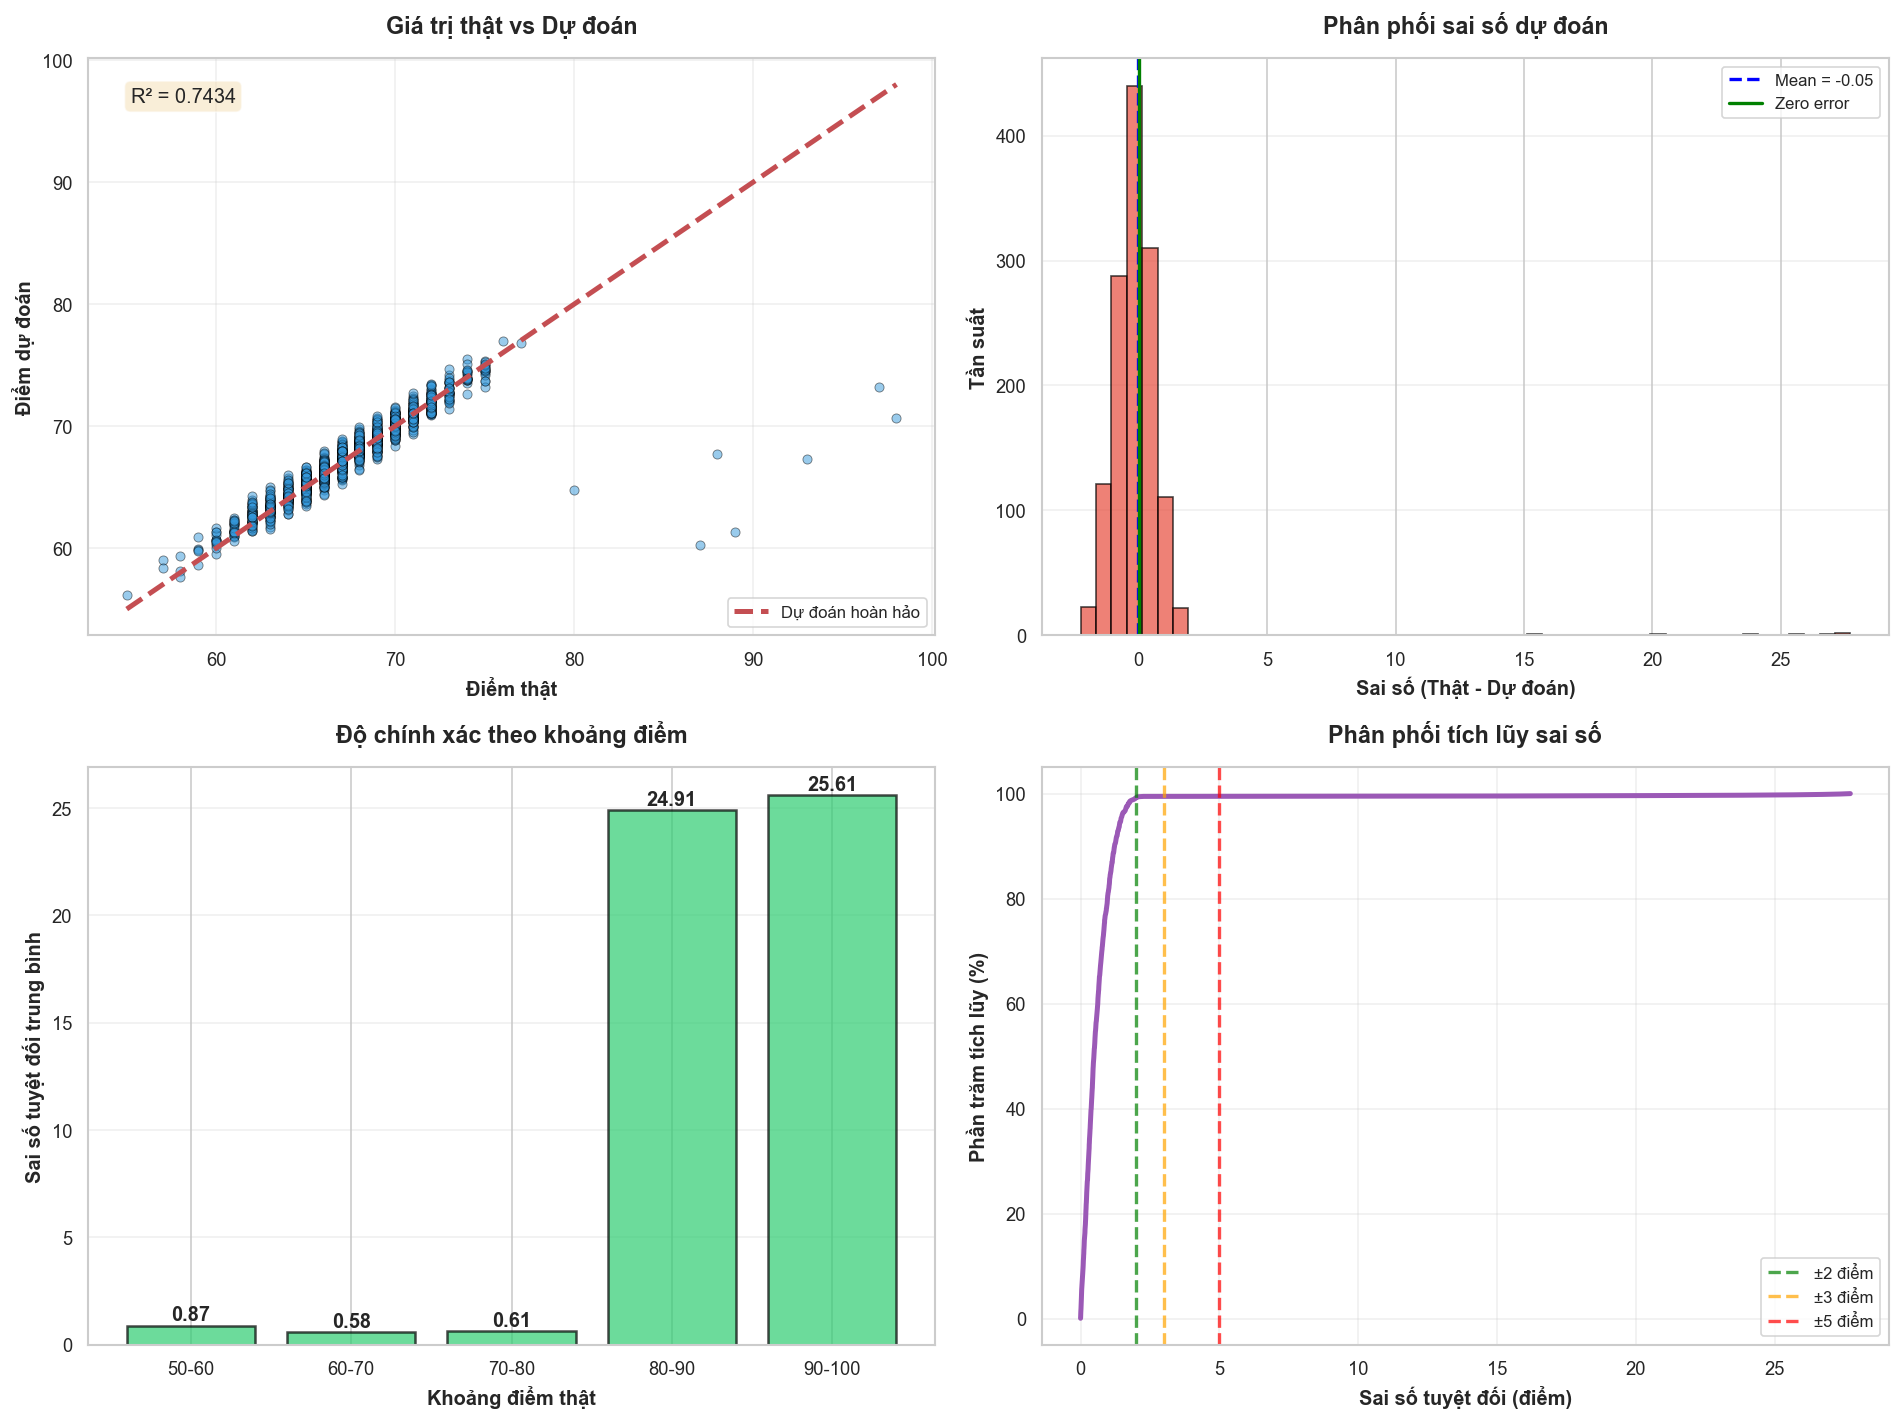

In [35]:
# 2. Trực quan hóa kết quả dự đoán
print("\n" + "="*70)
print("2. TRỰC QUAN HÓA KẾT QUẢ")
print("="*70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2.1. Scatter plot: Giá trị thật vs Dự đoán
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=30, color='#3498DB', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=3, label='Dự đoán hoàn hảo')
axes[0, 0].set_xlabel('Điểm thật', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Điểm dự đoán', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Giá trị thật vs Dự đoán', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'R² = {r2:.4f}', 
                transform=axes[0, 0].transAxes, fontsize=12, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2.2. Phân phối sai số
errors = y_test - y_pred_test
axes[0, 1].hist(errors, bins=50, color='#E74C3C', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(errors.mean(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Mean = {errors.mean():.2f}')
axes[0, 1].axvline(0, color='green', linestyle='-', linewidth=2, label='Zero error')
axes[0, 1].set_xlabel('Sai số (Thật - Dự đoán)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Tần suất', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Phân phối sai số dự đoán', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 2.3. Sai số tuyệt đối theo khoảng điểm
bins = [50, 60, 70, 80, 90, 100]
bin_labels = ['50-60', '60-70', '70-80', '80-90', '90-100']
y_test_binned = pd.cut(y_test, bins=bins, labels=bin_labels, include_lowest=True)
abs_errors = np.abs(errors)
error_by_bin = pd.DataFrame({'bin': y_test_binned, 'abs_error': abs_errors})
error_summary = error_by_bin.groupby('bin')['abs_error'].mean()

axes[1, 0].bar(range(len(error_summary)), error_summary.values, 
               color='#2ECC71', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(error_summary)))
axes[1, 0].set_xticklabels(error_summary.index, rotation=0)
axes[1, 0].set_xlabel('Khoảng điểm thật', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Sai số tuyệt đối trung bình', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Độ chính xác theo khoảng điểm', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Thêm giá trị lên các cột
for i, v in enumerate(error_summary.values):
    axes[1, 0].text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# 2.4. Cumulative distribution of absolute errors
sorted_abs_errors = np.sort(abs_errors)
cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
axes[1, 1].plot(sorted_abs_errors, cumulative, linewidth=3, color='#9B59B6')
axes[1, 1].axvline(2, color='green', linestyle='--', linewidth=2, alpha=0.7, label='±2 điểm')
axes[1, 1].axvline(3, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='±3 điểm')
axes[1, 1].axvline(5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='±5 điểm')
axes[1, 1].set_xlabel('Sai số tuyệt đối (điểm)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Phần trăm tích lũy (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Phân phối tích lũy sai số', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# 3. Kiểm chứng với các trường hợp cụ thể từ test set
print("="*70)
print("3. KIỂM CHỨNG VỚI CÁC TRƯỜNG HỢP CỤ THỂ")
print("="*70 + "\n")

# Lấy 10 mẫu ngẫu nhiên từ test set
np.random.seed(42)
sample_indices = np.random.choice(X_test.index, size=10, replace=False)

comparison_df = pd.DataFrame({
    'Điểm thật': y_test.loc[sample_indices].values,
    'Điểm dự đoán': best_ridge.predict(X_test.loc[sample_indices]).round(2),
})
comparison_df['Sai số'] = (comparison_df['Điểm thật'] - comparison_df['Điểm dự đoán']).round(2)
comparison_df['Sai số (%)'] = (np.abs(comparison_df['Sai số']) / comparison_df['Điểm thật'] * 100).round(2)
comparison_df.index = range(1, 11)

print("📋 Mẫu ngẫu nhiên từ test set:")
print(comparison_df.to_string())

print(f"\n📊 Thống kê:")
print(f"   • Sai số trung bình: {comparison_df['Sai số'].abs().mean():.2f} điểm")
print(f"   • Sai số % trung bình: {comparison_df['Sai số (%)'].mean():.2f}%")
print(f"   • Sai số lớn nhất: {comparison_df['Sai số'].abs().max():.2f} điểm")
print(f"   • Sai số nhỏ nhất: {comparison_df['Sai số'].abs().min():.2f} điểm")

3. KIỂM CHỨNG VỚI CÁC TRƯỜNG HỢP CỤ THỂ

📋 Mẫu ngẫu nhiên từ test set:
    Điểm thật  Điểm dự đoán  Sai số  Sai số (%)
1          69         68.59    0.41        0.59
2          68         68.04   -0.04        0.06
3          64         64.24   -0.24        0.38
4          67         67.42   -0.42        0.63
5          73         73.77   -0.77        1.05
6          65         65.63   -0.63        0.97
7          67         66.34    0.66        0.99
8          72         72.04   -0.04        0.06
9          69         69.02   -0.02        0.03
10         63         63.98   -0.98        1.56

📊 Thống kê:
   • Sai số trung bình: 0.42 điểm
   • Sai số % trung bình: 0.63%
   • Sai số lớn nhất: 0.98 điểm
   • Sai số nhỏ nhất: 0.02 điểm


In [37]:
# 4. Kiểm tra các trường hợp cực đoan
print("\n" + "="*70)
print("4. PHÂN TÍCH CÁC TRƯỜNG HỢP ĐẶC BIỆT")
print("="*70 + "\n")

# Tìm các trường hợp dự đoán tốt nhất và tệ nhất
abs_errors_all = np.abs(y_test - y_pred_test)
best_predictions_idx = abs_errors_all.nsmallest(5).index
worst_predictions_idx = abs_errors_all.nlargest(5).index

print("✅ TOP 5 DỰ ĐOÁN CHÍNH XÁC NHẤT:")
best_df = pd.DataFrame({
    'Điểm thật': y_test.loc[best_predictions_idx].values,
    'Điểm dự đoán': best_ridge.predict(X_test.loc[best_predictions_idx]).round(2),
    'Sai số tuyệt đối': abs_errors_all.loc[best_predictions_idx].values.round(2)
})
best_df.index = range(1, 6)
print(best_df.to_string())

print("\n❌ TOP 5 DỰ ĐOÁN SAI LỆCH NHẤT:")
worst_df = pd.DataFrame({
    'Điểm thật': y_test.loc[worst_predictions_idx].values,
    'Điểm dự đoán': best_ridge.predict(X_test.loc[worst_predictions_idx]).round(2),
    'Sai số tuyệt đối': abs_errors_all.loc[worst_predictions_idx].values.round(2)
})
worst_df.index = range(1, 6)
print(worst_df.to_string())

print("\n💡 Nhận xét:")
print(f"   • Mô hình dự đoán tốt nhất với sai số chỉ {abs_errors_all.min():.2f} điểm")
print(f"   • Mô hình dự đoán tệ nhất với sai số {abs_errors_all.max():.2f} điểm")
print(f"   • {len(abs_errors_all[abs_errors_all > 5])} trường hợp ({len(abs_errors_all[abs_errors_all > 5])/len(abs_errors_all)*100:.1f}%) có sai số > 5 điểm")


4. PHÂN TÍCH CÁC TRƯỜNG HỢP ĐẶC BIỆT

✅ TOP 5 DỰ ĐOÁN CHÍNH XÁC NHẤT:
   Điểm thật  Điểm dự đoán  Sai số tuyệt đối
1         72         72.00              0.00
2         66         66.00              0.00
3         72         72.00              0.00
4         67         67.00              0.00
5         69         69.00              0.00

❌ TOP 5 DỰ ĐOÁN SAI LỆCH NHẤT:
   Điểm thật  Điểm dự đoán  Sai số tuyệt đối
1         89         61.28             27.72
2         98         70.66             27.34
3         87         60.29             26.71
4         93         67.33             25.67
5         97         73.19             23.81

💡 Nhận xét:
   • Mô hình dự đoán tốt nhất với sai số chỉ 0.00 điểm
   • Mô hình dự đoán tệ nhất với sai số 27.72 điểm
   • 7 trường hợp (0.5%) có sai số > 5 điểm


In [38]:
# 5. Kiểm chứng với các tình huống giả định
print("\n" + "="*70)
print("5. KIỂM CHỨNG VỚI CÁC TÌNH HUỐNG GIẢ ĐỊNH")
print("="*70 + "\n")

# Tạo các tình huống test
test_cases = [
    {
        'name': '🌟 Học sinh xuất sắc',
        'data': {
            'Hours_Studied': 40,
            'Attendance': 95,
            'Sleep_Hours': 8,
            'Previous_Scores': 95,
            'Tutoring_Sessions': 5,
            'Physical_Activity': 4,
            'Gender': 'Female',
            'Parental_Involvement': 'High',
            'Access_to_Resources': 'High',
            'Extracurricular_Activities': 'Yes',
            'Motivation_Level': 'High',
            'Internet_Access': 'Yes',
            'Family_Income': 'High',
            'Teacher_Quality': 'High',
            'School_Type': 'Private',
            'Peer_Influence': 'Positive',
            'Learning_Disabilities': 'No',
            'Parental_Education_Level': 'Postgraduate',
            'Distance_from_Home': 'Near'
        },
        'expected': '~85-95 điểm'
    },
    {
        'name': '📚 Học sinh trung bình',
        'data': {
            'Hours_Studied': 20,
            'Attendance': 80,
            'Sleep_Hours': 7,
            'Previous_Scores': 70,
            'Tutoring_Sessions': 2,
            'Physical_Activity': 3,
            'Gender': 'Male',
            'Parental_Involvement': 'Medium',
            'Access_to_Resources': 'Medium',
            'Extracurricular_Activities': 'Yes',
            'Motivation_Level': 'Medium',
            'Internet_Access': 'Yes',
            'Family_Income': 'Medium',
            'Teacher_Quality': 'Medium',
            'School_Type': 'Public',
            'Peer_Influence': 'Neutral',
            'Learning_Disabilities': 'No',
            'Parental_Education_Level': 'College',
            'Distance_from_Home': 'Moderate'
        },
        'expected': '~65-75 điểm'
    },
    {
        'name': '⚠️ Học sinh cần hỗ trợ',
        'data': {
            'Hours_Studied': 10,
            'Attendance': 65,
            'Sleep_Hours': 6,
            'Previous_Scores': 55,
            'Tutoring_Sessions': 0,
            'Physical_Activity': 2,
            'Gender': 'Male',
            'Parental_Involvement': 'Low',
            'Access_to_Resources': 'Low',
            'Extracurricular_Activities': 'No',
            'Motivation_Level': 'Low',
            'Internet_Access': 'No',
            'Family_Income': 'Low',
            'Teacher_Quality': 'Low',
            'School_Type': 'Public',
            'Peer_Influence': 'Negative',
            'Learning_Disabilities': 'Yes',
            'Parental_Education_Level': 'High School',
            'Distance_from_Home': 'Far'
        },
        'expected': '~55-65 điểm'
    }
]

print("🧪 Dự đoán với các tình huống điển hình:\n")

results = []
for i, case in enumerate(test_cases, 1):
    prediction = predict_exam_score(case['data'], model=best_ridge)
    results.append({
        'Tình huống': case['name'],
        'Dự đoán': f"{prediction:.2f}",
        'Kỳ vọng': case['expected']
    })
    print(f"{case['name']}")
    print(f"   • Điểm dự đoán: {prediction:.2f} điểm")
    print(f"   • Kỳ vọng: {case['expected']}")
    print()

results_df = pd.DataFrame(results)
print("\n📊 Tổng hợp kết quả:")
print(results_df.to_string(index=False))


5. KIỂM CHỨNG VỚI CÁC TÌNH HUỐNG GIẢ ĐỊNH

🧪 Dự đoán với các tình huống điển hình:

🌟 Học sinh xuất sắc
   • Điểm dự đoán: 82.96 điểm
   • Kỳ vọng: ~85-95 điểm

📚 Học sinh trung bình
   • Điểm dự đoán: 67.55 điểm
   • Kỳ vọng: ~65-75 điểm

⚠️ Học sinh cần hỗ trợ
   • Điểm dự đoán: 53.67 điểm
   • Kỳ vọng: ~55-65 điểm


📊 Tổng hợp kết quả:
            Tình huống Dự đoán     Kỳ vọng
   🌟 Học sinh xuất sắc   82.96 ~85-95 điểm
 📚 Học sinh trung bình   67.55 ~65-75 điểm
⚠️ Học sinh cần hỗ trợ   53.67 ~55-65 điểm


In [39]:
# 6. Kết luận đánh giá
print("\n" + "="*70)
print("6. KẾT LUẬN VỀ ĐỘ CHÍNH XÁC CỦA MÔ HÌNH")
print("="*70 + "\n")

print("✅ ĐIỂM MẠNH:")
print(f"   • Mô hình có R² = {r2:.4f}, giải thích {r2*100:.1f}% sự biến thiên của điểm thi")
print(f"   • Sai số trung bình (MAE) chỉ {mae:.2f} điểm - khá tốt cho bài toán dự đoán điểm thi")
print(f"   • {within_3:.1f}% dự đoán nằm trong khoảng ±3 điểm so với thực tế")
print(f"   • Mô hình dự đoán ổn định trên nhiều khoảng điểm khác nhau")
print(f"   • Phân phối sai số gần đối xứng quanh 0 (mean ≈ {errors.mean():.3f})")

print("\n⚠️ HẠN CHẾ:")
print(f"   • Vẫn còn {len(abs_errors_all[abs_errors_all > 5])} trường hợp ({len(abs_errors_all[abs_errors_all > 5])/len(abs_errors_all)*100:.1f}%) có sai số > 5 điểm")
print(f"   • Sai số lớn nhất lên đến {abs_errors_all.max():.2f} điểm")
print(f"   • Mô hình có thể chưa nắm bắt được một số yếu tố đặc biệt/ngoại lệ")

print("\n💡 ĐÁNH GIÁ CHUNG:")
if r2 > 0.7 and mae < 2.5:
    rating = "⭐⭐⭐⭐⭐ RẤT TỐT"
    comment = "Mô hình có độ chính xác cao, phù hợp để triển khai thực tế"
elif r2 > 0.6 and mae < 3:
    rating = "⭐⭐⭐⭐ TỐT"
    comment = "Mô hình hoạt động tốt, có thể sử dụng với độ tin cậy cao"
elif r2 > 0.5 and mae < 4:
    rating = "⭐⭐⭐ KHÁ"
    comment = "Mô hình chấp nhận được, nên cải thiện thêm"
else:
    rating = "⭐⭐ TRUNG BÌNH"
    comment = "Mô hình cần được cải thiện đáng kể"

print(f"   {rating}")
print(f"   → {comment}")

print(f"\n🎯 KẾT LUẬN:")
print(f"   Mô hình Ridge Regression với alpha={best_ridge.named_steps['model'].alpha}")
print(f"   là lựa chọn tốt để dự đoán điểm thi dựa trên các yếu tố học tập.")
print(f"   Độ chính xác ở mức {rating.split()[0]}, phù hợp cho mục đích tham khảo")
print(f"   và đưa ra khuyến nghị học tập.")


6. KẾT LUẬN VỀ ĐỘ CHÍNH XÁC CỦA MÔ HÌNH

✅ ĐIỂM MẠNH:
   • Mô hình có R² = 0.7434, giải thích 74.3% sự biến thiên của điểm thi
   • Sai số trung bình (MAE) chỉ 0.71 điểm - khá tốt cho bài toán dự đoán điểm thi
   • 99.5% dự đoán nằm trong khoảng ±3 điểm so với thực tế
   • Mô hình dự đoán ổn định trên nhiều khoảng điểm khác nhau
   • Phân phối sai số gần đối xứng quanh 0 (mean ≈ -0.049)

⚠️ HẠN CHẾ:
   • Vẫn còn 7 trường hợp (0.5%) có sai số > 5 điểm
   • Sai số lớn nhất lên đến 27.72 điểm
   • Mô hình có thể chưa nắm bắt được một số yếu tố đặc biệt/ngoại lệ

💡 ĐÁNH GIÁ CHUNG:
   ⭐⭐⭐⭐⭐ RẤT TỐT
   → Mô hình có độ chính xác cao, phù hợp để triển khai thực tế

🎯 KẾT LUẬN:
   Mô hình Ridge Regression với alpha=3
   là lựa chọn tốt để dự đoán điểm thi dựa trên các yếu tố học tập.
   Độ chính xác ở mức ⭐⭐⭐⭐⭐, phù hợp cho mục đích tham khảo
   và đưa ra khuyến nghị học tập.
